# Case Analysis including actions

This Covid explainer will walk you through how to run the MDP Algorithm on the code (in the version used by `covid_team2`). Everything you need to run the code should already be here in this folder, as the MDP algorithm was modified for Covid specifically. Relevant files in this directory include: 
* `mdp_model.py`
* `mdp_clustering.py`
* `mdp_testing.py`
* `mdp_tools.py`
* `states_combined_data.csv`**

** Note: some rows or columns have been taken out to create this sample dataset, to accomodate missing data in the original dataset. 

## Creating Training Data

We will run one round of the demonstration that trains on data that ends at a date earlier than the last date we have on our dataset. This way we can compare how well our model predicts to the real value in our data. The last date in this `states_combined_data.csv` contains up to `5/29/20`. 

In [1]:
# Load Built-in Modules
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle

# Ignore Python package warnings (not verbose)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# paths
DIRECTORY_PATH = os.path.dirname(os.getcwd())
os.chdir(DIRECTORY_PATH)

DATA_PATH   = os.path.join(os.getcwd(), "data", "input")
RESULT_PATH = os.path.join(os.path.dirname(os.getcwd()), "results")
MODEL_PATH  = os.path.join(os.getcwd(), "models")

In [3]:
# experiment name
EXPERIMENT_FOLDER = "01 - Cross-validation by state"
try: 
    assert os.path.exists(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))
except AssertionError:
    os.mkdir(os.path.join(RESULT_PATH, EXPERIMENT_FOLDER))

In [4]:
# Load MDP packages
import codes.mdp_model as mdp
from codes.mdp_testing import mape, plot_pred
from codes.mdp_states_functions import createSamples
# from codes.utils import run_script # for multiprocessing

In [5]:
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))

In [6]:
for columns in df.columns :
    print("column name : {} - {} NaN".format(columns, df[columns].isnull().mean()))
    
print(df.isnull().mean().mean())

column name : Unnamed: 0 - 0.0 NaN
column name : state - 0.0 NaN
column name : date - 0.0 NaN
column name : cases - 0.0 NaN
column name : deaths - 0.0 NaN
column name : population - 0.034482758620689655 NaN
column name : emergdec - 0.0 NaN
column name : schoolclose - 0.0 NaN
column name : barrestrict - 0.0 NaN
column name : gathrestrict25 - 0.0 NaN
column name : gathrestrictany - 0.0 NaN
column name : otherbusinessclose - 0.0 NaN
column name : restaurantrestrict - 0.0 NaN
column name : gathrestrict10 - 0.0 NaN
column name : caseisolation - 0.0 NaN
column name : stayathome - 0.0 NaN
column name : publicmask - 0.0 NaN
column name : quarantine - 0.0 NaN
column name : nebusinessclose - 0.0 NaN
column name : travelrestrictintra - 0.0 NaN
column name : gathrestrict50 - 0.0 NaN
column name : gathrecomany - 0.0 NaN
column name : gathrestrict250 - 0.0 NaN
column name : gathrestrict5 - 0.0 NaN
column name : gathrestrict100 - 0.0 NaN
column name : gathrestrict1000 - 0.0 NaN
column name : gathrest

In [7]:
# Exception
df = df[df["state"]!='Guam']
df = df[df["state"]!='Northern Mariana Islands']
df = df[df["state"]!='Puerto Rico']
df = df[df["state"]!='Diamond Princess']
df = df[df["state"]!='Grand Princess']
df = df[df["state"]!='American Samoa']
df = df[df["state"]!='Virgin Islands']

In [8]:
df.dropna(subset=["population"], inplace=True)
df["cases_nom"] = df["cases"] / df["population"]
df["deaths_nom"] = df["deaths"] / df["population"]

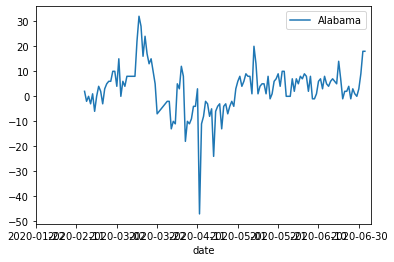

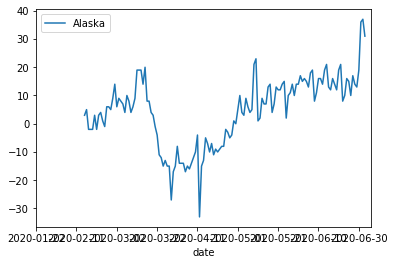

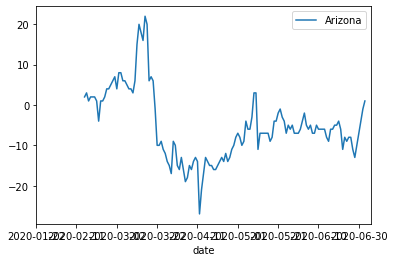

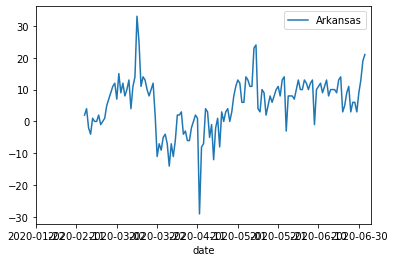

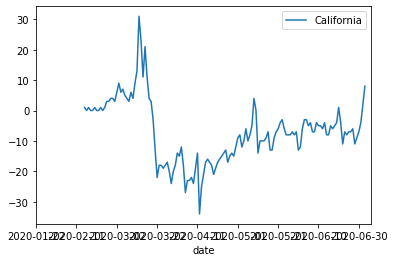

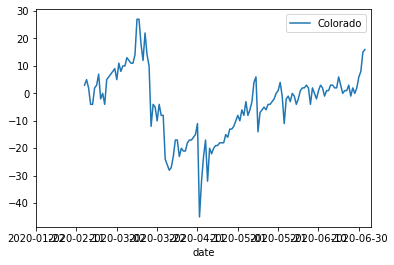

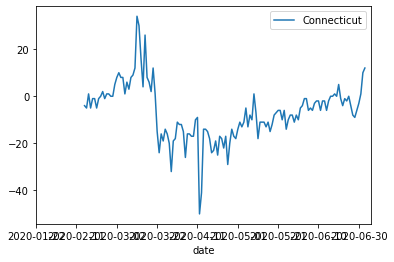

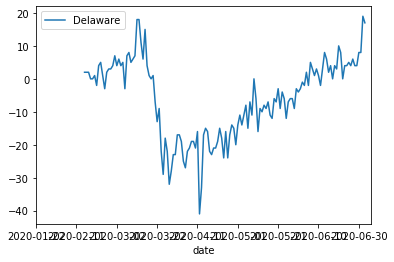

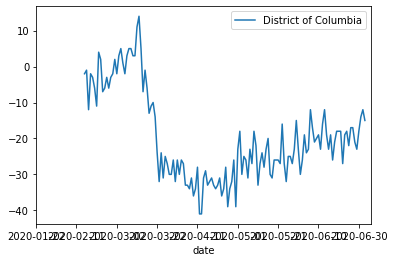

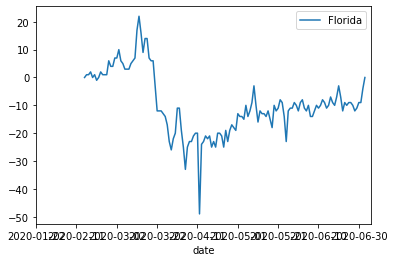

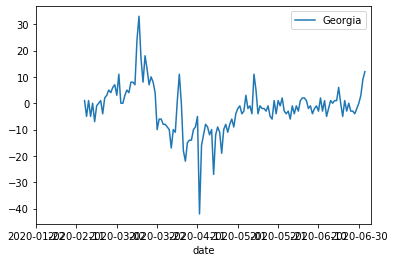

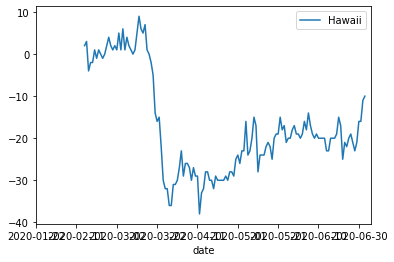

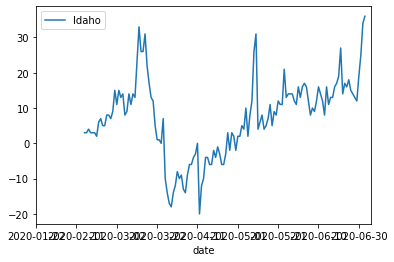

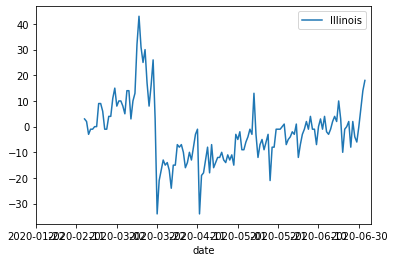

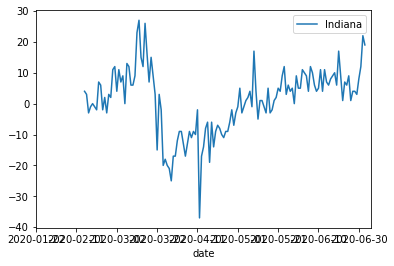

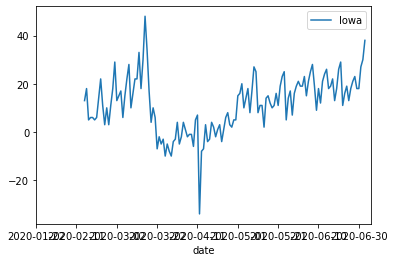

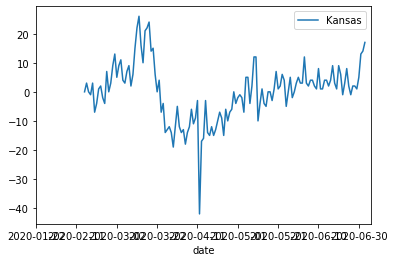

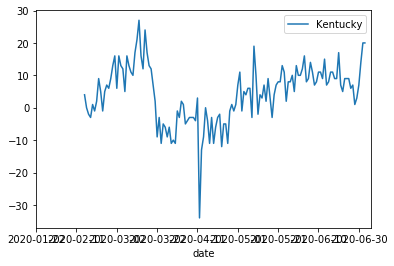

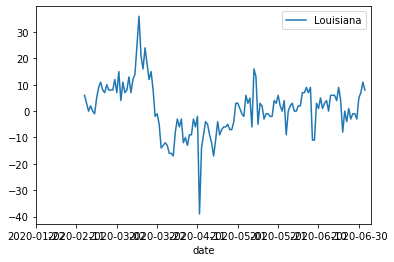

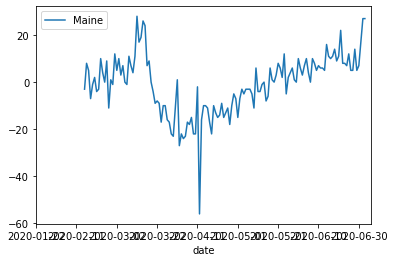

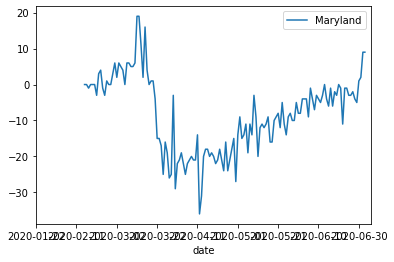

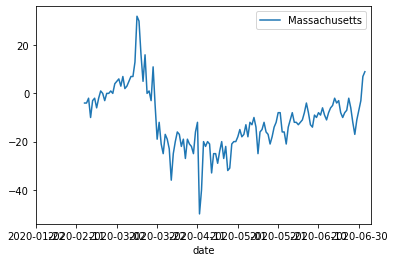

In [9]:
# plotting for a specific feature by region

feature = "grocery_and_pharmacy"
for id_, (name, group) in enumerate(df.groupby("state")):
    group.plot(x="date", y=feature, label=name)
    if id_ > 20 :
        break
plt.legend()
plt.show()

## New features

In [10]:
df.sort_values(by=["state", "date"], inplace=True)
df["cases_pct2"] = df.groupby("state")["cases"].pct_change(2)
df["cases_pct5"] = df.groupby("state")["cases"].pct_change(5)
df["cases_pct10"] = df.groupby("state")["cases"].pct_change(10)
df["deaths_pct2"] = df.groupby("state")["deaths"].pct_change(2)
df["deaths_pct5"] = df.groupby("state")["deaths"].pct_change(5)
df["cases_pct10"] = df.groupby("state")["cases"].pct_change(10)
df["residential_pct10"]= df.groupby("state")["residential"].pct_change(10)
# df["home_time_pct10"]= df.groupby("state")["home_time"].pct_change(10)

In [11]:
file_new = '07_08_2020_states_combined_w_pct.csv'
df.to_csv(os.path.join(DATA_PATH, file_new))

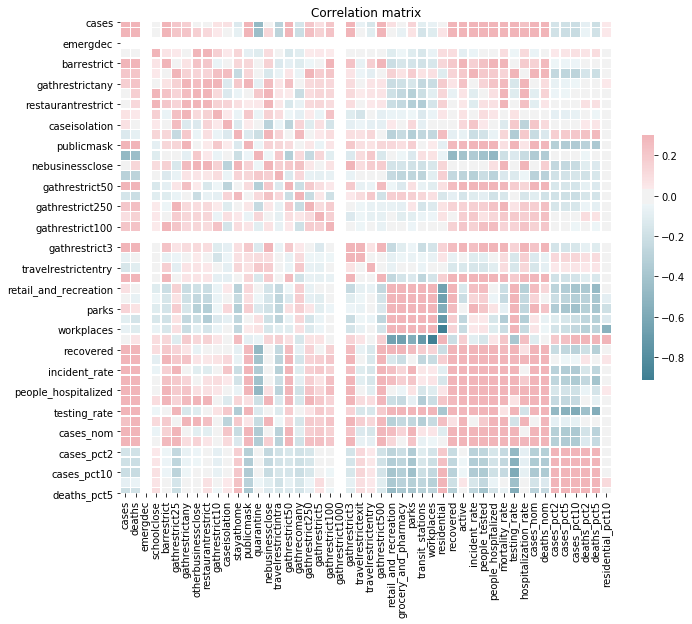

In [12]:
# plot for the covariance matrix between features 
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.loc[:, ~(df.columns.isin(["Unnamed: 0", "state", "date", "population"]))].dropna().corr(method="spearman"), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation matrix")
plt.show()

We can specify a value `n_days` to create a training dataset that ends `n_days` before this last date. We will also need to give the name of the date column from our `df`. 

## Testing models

Now that we understand how the samples are actually created, we can fit the samples to the model! Here, there are a few additional parameters that need to be set: 

`h` is the time horizon (in number of datapoints) that we take when calculating error. Essentially, we will be calculating the error of the most recent `h` points from the end. The goal of the algorithm is to minimize `testing_error`, so `testing_error` for a sequence of `h=1` points will be much smaller than for `h=5` points. If we are doing a 2 week prediction (`n_days = 14`), `h=5` while `d_avg=3` means that 5 datapoints correspond to a 15 day timespan, which means the algorithm will be minimizing error for around a 2 week period before the last date in the training data. If we take `h=-1`, the algorithm will try to minimize error over all the datapoints available in the training data.

`n_iter` is the maximum number of clusters we want the algorithm to stop at while training. Initial clustering is done using `clustering='Agglomerative'`, with a `distance_threshold = 0.1`, based on `RISK`. The algorithm will then split the cluster that contains the most contradictions (two points in the cluster taking the same action but ending up in different clusters), so one cluster becomes two. For points in the same cluster that don't take the action causing the contradiction, the group they enter is decided by `classification = 'DecisionTreeClassifier'`, which learns which group they are closer to based on their features. Splitting will stop when `n_iter` number of total clusters is reached.

`th` is the splitting threshold, which basically allows the split to happen if the number of points in contradiction within a cluster is greater than this `th` value. 

`model.fit` will also automatically run cross validation by splitting the dataset randomly into `cv=5` combinations of testing & training, where each `ID` (state) will be in the testing set exactly once. After cross validation, it will find the number of clusters that gives the smallest `testing_error`, and split the entire dataset once more to this exact number of clusters. Now let's run it!

In [102]:
# # Setting parameters
n_days = 30
target_colname = 'cases'
region_colname = 'state'
date_colname = 'date'
days_avg = 3


# model names deaths

In [103]:
# with open(os.path.join(MODEL_PATH, model_name), 'rb') as filehandler:
#     m = pickle.load(filehandler)

with open(r"C:\Users\david\Desktop\MIT\Courses\Research internship\results\16 - 20200810 TEST ERROR COMPUTATION EXPONENTIAL TESTING\MDPs_without_actions\mdp_20200615_cases_state.pickle", 'rb') as filehandler:
    m = pickle.load(filehandler)
# with open(r"C:\Users\david\Desktop\MIT\Courses\Research internship\results\12 - 20200723 UPDATED ERROR COMPUTATION\MDPs\mdp_cases_wo_act.pickle", 'rb') as filehandler:
#     m = pickle.load(filehandler)

## Analysis of the MDP

In [104]:
m.df_trained

ID       TIME  cases_pct3  cases_pct5  cases_pct3-1  \
state                                                                       
Alabama                0 2020-06-15    0.108056    0.194779      0.115615   
Alaska                 1 2020-06-15    0.062500    0.119932      0.092564   
Arizona                2 2020-06-13    0.139400    0.249452      0.134457   
Arkansas               3 2020-06-15    0.118646    0.245853      0.155965   
California             4 2020-06-13    0.065933    0.116809      0.071414   
Colorado               5 2020-06-15    0.016558    0.028086      0.017261   
Connecticut            6 2020-06-14    0.013160    0.020300      0.011501   
Delaware               7 2020-06-13    0.016418    0.026122      0.013391   
District of Columbia   8 2020-06-14    0.016791    0.029199      0.019445   
Florida                9 2020-06-13    0.091795    0.141992      0.064394   
Georgia               10 2020-06-14    0.048213    0.082687      0.049023   
Hawaii                11 2020-06-13    0.049997    0.070476      0.024558   
Idaho                 12 2020-06-15    0.013719    0.042638      0.037382   
Illinois              13 2020-06-15    0.013857    0.024485      0.015297   
Indiana               14 2020-06-13    0.031407    0.051651      0.028101   
Iowa                  15 2020-06-15    0.031349    0.064351      0.046585   
Kansas                16 2020-06-13    0.027445    0.048150      0.031276   
Kentucky              17 2020-06-14    0.040697    0.063666      0.042457   
Louisiana             18 2020-06-14    0.048330    0.070155      0.038637   
Maine                 19 2020-06-15    0.032709    0.065605      0.045626   
Maryland              20 2020-06-14    0.024198    0.045326      0.030219   
Massachusetts         21 2020-06-13    0.008948    0.016099      0.009423   
Michigan              22 2020-06-13    0.008522    0.012903      0.005442   
Minnesota             23 2020-06-15    0.030139    0.063182      0.043043   
Mississippi           24 2020-06-13    0.046591    0.078996      0.054630   
Missouri              25 2020-06-14    0.029100    0.049556      0.032173   
Montana               26 2020-06-13    0.059484    0.081131      0.030342   
Nebraska              27 2020-06-15    0.019913    0.049383      0.033208   
Nevada                28 2020-06-15    0.057081    0.107360      0.070452   
New Hampshire         29 2020-06-15    0.017901    0.032252      0.026053   
New Jersey            30 2020-06-14    0.006037    0.011639      0.007978   
New Mexico            31 2020-06-13    0.037200    0.064628      0.038190   
New York              32 2020-06-15    0.005842    0.009964      0.006258   
North Carolina        33 2020-06-14    0.103746    0.180822      0.103393   
North Dakota          34 2020-06-13    0.033841    0.059304      0.034109   
Ohio                  35 2020-06-14    0.028548    0.050637      0.031505   
Oklahoma              36 2020-06-13    0.076848    0.121058      0.057004   
Oregon                37 2020-06-15    0.082388    0.150198      0.072275   
Pennsylvania          38 2020-06-15    0.013433    0.027953      0.018832   
Rhode Island          39 2020-06-15    0.009155    0.021389      0.011265   
South Carolina        40 2020-06-15    0.128596    0.229647      0.136685   
South Dakota          41 2020-06-13    0.038129    0.063960      0.035213   
Tennessee             42 2020-06-13    0.064472    0.101549      0.053211   
Texas                 43 2020-06-15    0.062218    0.116791      0.077618   
Utah                  44 2020-06-13    0.080944    0.136623      0.074223   
Vermont               45 2020-06-14    0.011679    0.034902      0.030748   
Virginia              46 2020-06-14    0.033395    0.052710      0.029379   
Washington            47 2020-06-14    0.040894    0.067422      0.037620   
West Virginia         48 2020-06-15    0.032459    0.058341      0.035425   
Wisconsin             49 2020-06-13    0.037207    0.066803      0.040870   
Wyoming           

In [105]:
m.features_list

['cases_pct3', 'cases_pct5']

In [106]:
m.clustering_distance_threshold

0.06

We have our model ready for interpretation! Let's first look at some attributes that were stored in the model after training. First, we can see how many clusters it actually ended up with at the final optimal split, as well as the training error of the lowest point of CV: 

In [107]:
print(m.optimal_cluster_size)
print(m.CV_error)
m.verbose=2

400
None


Now, we can run `model.predict_region_ndays`, which takes a state name and a time horizon `n_days`, and returns the predicted number of cases after `n_days` from the most recent datapoint. (For later comparison purposes, since we created the training data using `n_days = 15`, we should pick an `n_days` that is less than that to compare with the real value.)

In [94]:
m.predict_region_ndays('Massachusetts', n_days)

current date: 2020-06-13 00:00:00 | current cases: 105562.66666666667
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0, 117.0, 115.0]
Prediction for date: 2020-07-13 00:00:00 | target: EST_RISK    111410.66832
dtype: float64


EST_RISK    111410.66832
dtype: float64

`model.predict_all` does the same thing, but for all the states for a given `n_days`. It returns a dataframe instead of just a number.

In [96]:
m.predict_allregions_ndays(n_days)

current date: 2020-06-15 00:00:00 | current cases: 26272.0
predicted initial cluster 33
Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-15 00:00:00 | target: EST_RISK    39681.78479
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 663.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0, 378.0, 43.0, 295.0, 392.0]
Prediction for date: 2020-07-15 00:00:00 | target: EST_RISK    740.473152
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 35736.666666666664
predicted initial cluster 6
Sequence of clusters: [6, 366.0, 338.0, 6.0, 366.0, 338.0, 6.0, 366.0, 338.0, 6.0, 366.0]
Prediction for date: 2020-07-13 00:00:00 | target: EST_RISK    108689.864443
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 12917.0
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372

Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-15 00:00:00 | target: EST_RISK    30491.018709
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 5886.333333333333
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-13 00:00:00 | target: EST_RISK    6672.546443
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 30298.666666666668
predicted initial cluster 33
Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-13 00:00:00 | target: EST_RISK    45763.747339
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 90211.0
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-15 00:00:00 | target: EST_RISK    102260.10

TIME   cases
state                                  
Alabama              2020-07-15   39681
Alaska               2020-07-15     740
Arizona              2020-07-13  108689
Arkansas             2020-07-15   20324
California           2020-07-13  230645
Colorado             2020-07-15   30906
Connecticut          2020-07-14   47663
Delaware             2020-07-13   13671
District of Columbia 2020-07-14   10324
Florida              2020-07-13  119519
Georgia              2020-07-14   65800
Hawaii               2020-07-13    1090
Idaho                2020-07-15    3587
Illinois             2020-07-15  140384
Indiana              2020-07-13   44630
Iowa                 2020-07-15   32033
Kansas               2020-07-13   12449
Kentucky             2020-07-14   14012
Louisiana            2020-07-14   53159
Maine                2020-07-15    3737
Maryland             2020-07-14   82293
Massachusetts        2020-07-13  111410
Michigan             2020-07-13   69647
Minnesota            2020-07-15   40827
Mississippi          2020-07-13   29254
Missouri             2020-07-14   21863
Montana              2020-07-13     867
Nebraska             2020-07-15   17784
Nevada               2020-07-15   12637
New Hampshire        2020-07-15    5641
New Jersey           2020-07-14  176243
New Mexico           2020-07-13   11029
New York             2020-07-15  405213
North Carolina       2020-07-14   70761
North Dakota         2020-07-13    3439
Ohio                 2020-07-14   55018
Oklahoma             2020-07-13   12966
Oregon               2020-07-15    8790
Pennsylvania         2020-07-15   88219
Rhode Island         2020-07-15   16984
South Carolina       2020-07-15   30491
South Dakota         2020-07-13    6672
Tennessee            2020-07-13   45763
Texas                2020-07-15  102260
Utah                 2020-07-13   22643
Vermont              2020-07-14    1189
Virginia             2020-07-14   61087
Washington           2020-07-14   29033
West Virginia        2020-07-15    3088
Wisconsin            2020-07-13   25772
Wyoming              2020-07-14    1212

We can run the following code to visualize the comparative errors between predicted and actual errors in a dataframe.

In [97]:
# Import full dataset and convert time col to time object
file = r'C:\Users\david\Dropbox (MIT)\COVID-19-Team2\Data\07_16_2020_states_combined.csv'
df = pd.read_csv(file)
df.loc[:, [date_colname]]= pd.to_datetime(df[date_colname])

df_pred = pd.concat([m.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m.region_colname, "TIME"]).join(df.rename(columns={m.date_colname: "TIME"}).set_index([m.region_colname, "TIME"])[m.target_colname], lsuffix="_", rsuffix="").loc[:, [m.target_colname]].reset_index().set_index(m.region_colname)
df_pred.set_index(m.region_colname, inplace=True)
error = mape(df_pred, df_true, m.target_colname).reset_index()
error_state = error.dropna().drop("TIME", axis=1).groupby(m.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

current date: 2020-06-15 00:00:00 | current cases: 26272.0
predicted initial cluster 33
Sequence of clusters: [33]
Prediction for date: 2020-06-16 00:00:00 | target: EST_RISK    26835.972481
Name: 33, dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 663.0
predicted initial cluster 17
Sequence of clusters: [17]
Prediction for date: 2020-06-16 00:00:00 | target: EST_RISK    669.55797
Name: 17, dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 35736.666666666664
predicted initial cluster 6
Sequence of clusters: [6]
Prediction for date: 2020-06-14 00:00:00 | target: EST_RISK    37208.578856
Name: 6, dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 12917.0
predicted initial cluster 7
Sequence of clusters: [7]
Prediction for date: 2020-06-16 00:00:00 | target: EST_RISK    13230.432819
Name: 7, dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 152703.0
predicted initial cluster 33
Sequence of clusters: [33]
Prediction for date:

current date: 2020-06-15 00:00:00 | current cases: 12917.0
predicted initial cluster 7
Sequence of clusters: [7, 340.0]
Prediction for date: 2020-06-17 00:00:00 | target: EST_RISK    13630.068801
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 152703.0
predicted initial cluster 33
Sequence of clusters: [33, 396.0]
Prediction for date: 2020-06-15 00:00:00 | target: EST_RISK    159314.705233
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 29284.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0]
Prediction for date: 2020-06-17 00:00:00 | target: EST_RISK    29505.560478
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 45161.5
predicted initial cluster 13
Sequence of clusters: [13, 53.0]
Prediction for date: 2020-06-16 00:00:00 | target: EST_RISK    45503.188415
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 10277.666666666666
predicted initial cluster 29
Sequence of clusters: [29, 43.0]
Prediction for dat

Sequence of clusters: [13, 53.0]
Prediction for date: 2020-06-18 00:00:00 | target: EST_RISK    29563.924443
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 45161.5
predicted initial cluster 13
Sequence of clusters: [13, 53.0]
Prediction for date: 2020-06-17 00:00:00 | target: EST_RISK    45593.196754
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 10277.666666666666
predicted initial cluster 29
Sequence of clusters: [29, 43.0]
Prediction for date: 2020-06-16 00:00:00 | target: EST_RISK    10481.914936
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 9783.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0]
Prediction for date: 2020-06-17 00:00:00 | target: EST_RISK    9876.515259
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 75482.0
predicted initial cluster 4
Sequence of clusters: [4, 33.0]
Prediction for date: 2020-06-16 00:00:00 | target: EST_RISK    82155.892522
dtype: float64
current date: 2020-06

Sequence of clusters: [33, 396.0]
Prediction for date: 2020-06-19 00:00:00 | target: EST_RISK    28604.216393
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 663.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0]
Prediction for date: 2020-06-19 00:00:00 | target: EST_RISK    685.967438
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 35736.666666666664
predicted initial cluster 6
Sequence of clusters: [6, 366.0]
Prediction for date: 2020-06-17 00:00:00 | target: EST_RISK    41696.896733
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 12917.0
predicted initial cluster 7
Sequence of clusters: [7, 340.0]
Prediction for date: 2020-06-19 00:00:00 | target: EST_RISK    14135.124075
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 152703.0
predicted initial cluster 33
Sequence of clusters: [33, 396.0]
Prediction for date: 2020-06-17 00:00:00 | target: EST_RISK    166258.741469
dtype: float64
current date: 2020

Sequence of clusters: [4, 33.0]
Prediction for date: 2020-06-17 00:00:00 | target: EST_RISK    15899.219511
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 1127.5
predicted initial cluster 13
Sequence of clusters: [13, 53.0]
Prediction for date: 2020-06-18 00:00:00 | target: EST_RISK    1140.529311
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 54696.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0]
Prediction for date: 2020-06-18 00:00:00 | target: EST_RISK    56590.761662
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 25996.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0]
Prediction for date: 2020-06-18 00:00:00 | target: EST_RISK    26896.545271
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 2322.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0]
Prediction for date: 2020-06-19 00:00:00 | target: EST_RISK    2374.773859
dtype: float64
current date: 2020-06-13 00:00:

Sequence of clusters: [13, 53.0, 52.0]
Prediction for date: 2020-06-21 00:00:00 | target: EST_RISK    135085.960163
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 39960.666666666664
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0]
Prediction for date: 2020-06-19 00:00:00 | target: EST_RISK    41720.999821
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 24082.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0]
Prediction for date: 2020-06-21 00:00:00 | target: EST_RISK    24767.403472
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 11146.666666666666
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0]
Prediction for date: 2020-06-19 00:00:00 | target: EST_RISK    11637.695684
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 12546.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0]
Prediction for date: 2020-06-20 00:00:00 | target: EST_RISK   

Sequence of clusters: [29, 43.0, 295.0]
Prediction for date: 2020-06-20 00:00:00 | target: EST_RISK    10605.814777
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 9783.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0]
Prediction for date: 2020-06-21 00:00:00 | target: EST_RISK    9968.937559
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 75482.0
predicted initial cluster 4
Sequence of clusters: [4, 33.0, 396.0]
Prediction for date: 2020-06-20 00:00:00 | target: EST_RISK    89449.030438
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 58047.5
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0]
Prediction for date: 2020-06-21 00:00:00 | target: EST_RISK    61910.986001
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 729.0
predicted initial cluster 28
Sequence of clusters: [28, 158.0, 3.0]
Prediction for date: 2020-06-20 00:00:00 | target: EST_RISK    821.360511
dtype: float64
cur

Sequence of clusters: [29, 43.0, 295.0, 392.0]
Prediction for date: 2020-06-23 00:00:00 | target: EST_RISK    31418.746446
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 19554.333333333332
predicted initial cluster 28
Sequence of clusters: [28, 158.0, 3.0, 392.0]
Prediction for date: 2020-06-21 00:00:00 | target: EST_RISK    22513.242263
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 16436.5
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0]
Prediction for date: 2020-06-22 00:00:00 | target: EST_RISK    16825.146645
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 599.3333333333334
predicted initial cluster 3
Sequence of clusters: [3, 392.0, 352.0, 372.0]
Prediction for date: 2020-06-21 00:00:00 | target: EST_RISK    680.142527
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 16851.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0]
Prediction for date: 2020-06-23 00

dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 44689.0
predicted initial cluster 4
Sequence of clusters: [4, 33.0, 396.0, 392.0]
Prediction for date: 2020-06-23 00:00:00 | target: EST_RISK    55266.441178
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 3079.6666666666665
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0]
Prediction for date: 2020-06-22 00:00:00 | target: EST_RISK    3254.032887
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 41362.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0]
Prediction for date: 2020-06-23 00:00:00 | target: EST_RISK    42970.875904
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 8240.333333333334
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0]
Prediction for date: 2020-06-22 00:00:00 | target: EST_RISK    9881.269628
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 5820.0
predicted

Sequence of clusters: [35, 69.0, 325.0, 13.0]
Prediction for date: 2020-06-25 00:00:00 | target: EST_RISK    97857.959787
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 14300.666666666666
predicted initial cluster 4
Sequence of clusters: [4, 33.0, 396.0, 392.0]
Prediction for date: 2020-06-23 00:00:00 | target: EST_RISK    17949.002115
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 1127.5
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0]
Prediction for date: 2020-06-24 00:00:00 | target: EST_RISK    1159.192203
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 54696.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0]
Prediction for date: 2020-06-24 00:00:00 | target: EST_RISK    57905.502807
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 25996.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0]
Prediction for date: 2020-06-24 00:00:00 | ta

Sequence of clusters: [4, 33.0, 396.0, 392.0, 352.0]
Prediction for date: 2020-06-24 00:00:00 | target: EST_RISK    18258.046671
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 1127.5
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0]
Prediction for date: 2020-06-25 00:00:00 | target: EST_RISK    1161.059437
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 54696.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0]
Prediction for date: 2020-06-25 00:00:00 | target: EST_RISK    57994.775919
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 25996.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0]
Prediction for date: 2020-06-25 00:00:00 | target: EST_RISK    27563.847352
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 2322.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0]
Prediction for date: 2

Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0]
Prediction for date: 2020-06-26 00:00:00 | target: EST_RISK    11302.35671
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 9783.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0]
Prediction for date: 2020-06-27 00:00:00 | target: EST_RISK    10127.361899
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 75482.0
predicted initial cluster 4
Sequence of clusters: [4, 33.0, 396.0, 392.0, 352.0]
Prediction for date: 2020-06-26 00:00:00 | target: EST_RISK    98811.175853
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 58047.5
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0]
Prediction for date: 2020-06-27 00:00:00 | target: EST_RISK    63494.024042
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 729.0
predicted initial cluster 28
Sequence of clusters: [28, 158.0, 3.0, 392.0, 352.0]
Prediction for date: 2020

Prediction for date: 2020-06-28 00:00:00 | target: EST_RISK    10168.392232
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 75482.0
predicted initial cluster 4
Sequence of clusters: [4, 33.0, 396.0, 392.0, 352.0, 372.0]
Prediction for date: 2020-06-27 00:00:00 | target: EST_RISK    100303.920301
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 58047.5
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0]
Prediction for date: 2020-06-28 00:00:00 | target: EST_RISK    63529.990424
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 729.0
predicted initial cluster 28
Sequence of clusters: [28, 158.0, 3.0, 392.0, 352.0, 372.0]
Prediction for date: 2020-06-27 00:00:00 | target: EST_RISK    915.291368
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 3399.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0]
Prediction for date: 2020-06-29 00:00:00 | target: ES

Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0]
Prediction for date: 2020-06-28 00:00:00 | target: EST_RISK    58464.017042
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 25996.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0]
Prediction for date: 2020-06-28 00:00:00 | target: EST_RISK    27786.869004
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 2322.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0]
Prediction for date: 2020-06-29 00:00:00 | target: EST_RISK    2592.080811
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 22736.0
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0]
Prediction for date: 2020-06-27 00:00:00 | target: EST_RISK    24883.377618
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 1069.5
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53

predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0]
Prediction for date: 2020-06-30 00:00:00 | target: EST_RISK    25654.541646
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 5886.333333333333
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0]
Prediction for date: 2020-06-28 00:00:00 | target: EST_RISK    6464.137913
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 30298.666666666668
predicted initial cluster 33
Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-06-28 00:00:00 | target: EST_RISK    38504.71423
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 90211.0
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0]
Prediction for date: 2020-06-30 00:00:00 | target: EST_RISK    99066.143931
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 14300.666666666666
predicted initial 

Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0]
Prediction for date: 2020-06-29 00:00:00 | target: EST_RISK    3300.818587
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 41362.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0]
Prediction for date: 2020-06-30 00:00:00 | target: EST_RISK    47107.868154
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 8240.333333333334
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0]
Prediction for date: 2020-06-29 00:00:00 | target: EST_RISK    11046.696134
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 5820.0
predicted initial cluster 33
Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-01 00:00:00 | target: EST_RISK    7489.376984
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 83589.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.

Sequence of clusters: [4, 33.0, 396.0, 392.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-01 00:00:00 | target: EST_RISK    61045.551752
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 3079.6666666666665
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0]
Prediction for date: 2020-06-30 00:00:00 | target: EST_RISK    3298.984299
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 41362.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-01 00:00:00 | target: EST_RISK    47464.261728
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 8240.333333333334
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0]
Prediction for date: 2020-06-30 00:00:00 | target: EST_RISK    11213.579021
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 5820.0
predicted initial cluster 33

Prediction for date: 2020-07-02 00:00:00 | target: EST_RISK    52024.559123
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 2810.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-03 00:00:00 | target: EST_RISK    3265.155278
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 61866.5
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-02 00:00:00 | target: EST_RISK    71887.448053
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 105562.66666666667
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0]
Prediction for date: 2020-07-01 00:00:00 | target: EST_RISK    110258.54145
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 65991.66666666667
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0]

Sequence of clusters: [6, 366.0, 338.0, 6.0, 366.0, 338.0, 6.0]
Prediction for date: 2020-07-02 00:00:00 | target: EST_RISK    72050.168956
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 12917.0
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0]
Prediction for date: 2020-07-04 00:00:00 | target: EST_RISK    17933.568935
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 152703.0
predicted initial cluster 33
Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-02 00:00:00 | target: EST_RISK    203510.918943
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 29284.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0]
Prediction for date: 2020-07-04 00:00:00 | target: EST_RISK    30623.918892
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 45161.5
predicted initial cluster 13
Sequence of cluster

Prediction for date: 2020-07-03 00:00:00 | target: EST_RISK    1179.089897
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 54696.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0]
Prediction for date: 2020-07-03 00:00:00 | target: EST_RISK    58977.26586
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 25996.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0]
Prediction for date: 2020-07-03 00:00:00 | target: EST_RISK    28030.806701
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 2322.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-04 00:00:00 | target: EST_RISK    2732.071461
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 22736.0
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0]
Prediction for date: 202

Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-05 00:00:00 | target: EST_RISK    7815.133659
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 83589.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-05 00:00:00 | target: EST_RISK    87460.07912
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 16093.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-05 00:00:00 | target: EST_RISK    16838.280794
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 19378.0
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-05 00:00:00 | target: EST_RISK    27107.364637
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 5886.333333333333
predicted initi

dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 16436.5
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-05 00:00:00 | target: EST_RISK    19829.137436
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 599.3333333333334
predicted initial cluster 3
Sequence of clusters: [3, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-04 00:00:00 | target: EST_RISK    786.436108
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 16851.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-06 00:00:00 | target: EST_RISK    17664.973918
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 11315.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0, 378.0]
Prediction for date: 2020-07-06 00:00:00 | target: EST_RISK

Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0]
Prediction for date: 2020-07-06 00:00:00 | target: EST_RISK    64978.132869
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 729.0
predicted initial cluster 28
Sequence of clusters: [28, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-05 00:00:00 | target: EST_RISK    999.126144
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 3399.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-07 00:00:00 | target: EST_RISK    3569.974157
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 133016.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-07 00:00:00 | target: EST_RISK    139706.879223
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 39960.666666666664
predicted initial c

Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-06 00:00:00 | target: EST_RISK    1184.214728
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 54696.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0, 378.0]
Prediction for date: 2020-07-06 00:00:00 | target: EST_RISK    59566.173926
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 25996.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0, 378.0]
Prediction for date: 2020-07-06 00:00:00 | target: EST_RISK    28310.703843
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 2322.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-07 00:00:00 | target: EST_RISK    2829.498667
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 22736.0
predicted initial cluste

dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 16093.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0]
Prediction for date: 2020-07-08 00:00:00 | target: EST_RISK    16975.753302
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 19378.0
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-08 00:00:00 | target: EST_RISK    28213.94252
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 5886.333333333333
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0]
Prediction for date: 2020-07-06 00:00:00 | target: EST_RISK    6615.832786
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 30298.666666666668
predicted initial cluster 33
Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 202

Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0]
Prediction for date: 2020-07-09 00:00:00 | target: EST_RISK    17766.126814
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 11315.0
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0, 378.0, 43.0]
Prediction for date: 2020-07-09 00:00:00 | target: EST_RISK    12405.771363
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 5345.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0]
Prediction for date: 2020-07-09 00:00:00 | target: EST_RISK    5635.270775
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 166992.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0]
Prediction for date: 2020-07-08 00:00:00 | target: EST_RISK    176060.830158
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 9729.666

Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0]
Prediction for date: 2020-07-09 00:00:00 | target: EST_RISK    10308.943701
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 75482.0
predicted initial cluster 4
Sequence of clusters: [4, 33.0, 396.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-08 00:00:00 | target: EST_RISK    113114.110028
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 58047.5
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0]
Prediction for date: 2020-07-09 00:00:00 | target: EST_RISK    65400.943744
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 729.0
predicted initial cluster 28
Sequence of clusters: [28, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-08 00:00:00 | target: EST_RISK    1032.18666
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 3399.0
p

Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-10 00:00:00 | target: EST_RISK    28785.208281
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 5886.333333333333
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0]
Prediction for date: 2020-07-08 00:00:00 | target: EST_RISK    6632.012665
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 30298.666666666668
predicted initial cluster 33
Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-08 00:00:00 | target: EST_RISK    43203.508923
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 90211.0
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0]
Prediction for date: 2020-07-10 00:00:00 | target: EST_RISK    101638.908413
dtype: float64
current date: 2020-06-13 00:00:00 

Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-10 00:00:00 | target: EST_RISK    79059.230732
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 105562.66666666667
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0, 117.0]
Prediction for date: 2020-07-09 00:00:00 | target: EST_RISK    111026.791603
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 65991.66666666667
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0, 117.0]
Prediction for date: 2020-07-09 00:00:00 | target: EST_RISK    69407.521181
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 30693.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-11 00:00:00 | target: EST_RISK    39222.599773
dtype: float64
cu

Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0, 378.0, 43.0, 295.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    733.034757
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 35736.666666666664
predicted initial cluster 6
Sequence of clusters: [6, 366.0, 338.0, 6.0, 366.0, 338.0, 6.0, 366.0, 338.0, 6.0]
Prediction for date: 2020-07-10 00:00:00 | target: EST_RISK    96294.597517
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 12917.0
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    19576.167991
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 152703.0
predicted initial cluster 33
Sequence of clusters: [33, 396.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-10 00:00:00 | target: EST_RISK    222151.204357
dtype: float64
current date: 202

Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0, 117.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    87991.620184
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 16093.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0, 117.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    16940.615914
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 19378.0
predicted initial cluster 7
Sequence of clusters: [7, 340.0, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    29368.040825
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 5886.333333333333
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0]
Prediction for date: 2020-07-10 00:00:00 | target: EST_RISK    6648.232114
dtype: float64
current date: 2020-06-1

Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    53029.919741
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 2810.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-13 00:00:00 | target: EST_RISK    3663.607639
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 61866.5
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    80659.993601
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 105562.66666666667
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0, 117.0]
Prediction for date: 2020-07-11 00:00:00 | target: EST_RISK    111218.56434
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 65991.66666666667
predicted initial cluster 13
Se

Sequence of clusters: [28, 158.0, 3.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    1077.082476
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 3399.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0, 117.0, 115.0]
Prediction for date: 2020-07-14 00:00:00 | target: EST_RISK    3576.238522
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 133016.0
predicted initial cluster 13
Sequence of clusters: [13, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0, 119.0, 117.0, 115.0]
Prediction for date: 2020-07-14 00:00:00 | target: EST_RISK    139952.028008
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 39960.666666666664
predicted initial cluster 17
Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0, 378.0, 43.0, 295.0, 392.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    43974.949653
dtype

Sequence of clusters: [17, 124.0, 49.0, 122.0, 47.0, 120.0, 45.0, 378.0, 43.0, 295.0, 392.0]
Prediction for date: 2020-07-13 00:00:00 | target: EST_RISK    28607.450439
dtype: float64
current date: 2020-06-15 00:00:00 | current cases: 2322.0
predicted initial cluster 29
Sequence of clusters: [29, 43.0, 295.0, 392.0, 352.0, 372.0, 352.0, 372.0, 352.0, 372.0, 352.0]
Prediction for date: 2020-07-14 00:00:00 | target: EST_RISK    3050.268928
dtype: float64
current date: 2020-06-13 00:00:00 | current cases: 22736.0
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-12 00:00:00 | target: EST_RISK    25723.746926
dtype: float64
current date: 2020-06-14 00:00:00 | current cases: 1069.5
predicted initial cluster 35
Sequence of clusters: [35, 69.0, 325.0, 13.0, 53.0, 52.0, 51.0, 123.0, 48.0, 121.0, 46.0]
Prediction for date: 2020-07-13 00:00:00 | target: EST_RISK    1210.043426
dtype: float64


rel_error
state                          
Massachusetts          0.007581
Connecticut            0.008528
New Jersey             0.008639
Rhode Island           0.009292
New York               0.009648
District of Columbia   0.017202
Maine                  0.021506
Delaware               0.024940
Michigan               0.030258
Vermont                0.034307
New Hampshire          0.038820
Illinois               0.041878
South Dakota           0.041896
Hawaii                 0.042136
Maryland               0.043343
Minnesota              0.044082
Pennsylvania           0.053954
Indiana                0.054412
Virginia               0.062999
Iowa                   0.071570
North Dakota           0.074225
Colorado               0.077630
North Carolina         0.078774
Mississippi            0.081391
Nebraska               0.088857
Ohio                   0.092216
Tennessee              0.101651
Utah                   0.102506
New Mexico             0.104888
Wisconsin              0.112731
California             0.123995
Arizona                0.124425
Louisiana              0.125083
Alabama                0.128286
Missouri               0.130445
Kentucky               0.133407
West Virginia          0.136137
Washington             0.142614
Kansas                 0.152531
Oregon                 0.157833
Oklahoma               0.169527
Arkansas               0.171370
Wyoming                0.180472
Georgia                0.203916
Montana                0.205819
Alaska                 0.254522
Florida                0.260892
South Carolina         0.277119
Nevada                 0.315885
Texas                  0.368752
Idaho                  0.391095

In [98]:
# computing the out of sample error
error_state.describe()

rel_error
count  51.000000
mean    0.112470
std     0.092458
min     0.007581
25%     0.042016
50%     0.092216
75%     0.147572
max     0.391095

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028FBAED2908>]],
      dtype=object)

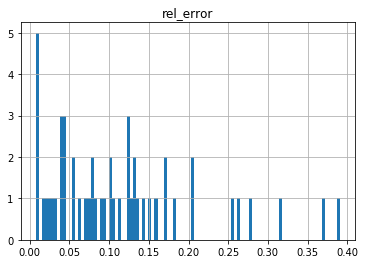

In [99]:
error_state.hist(bins=100)

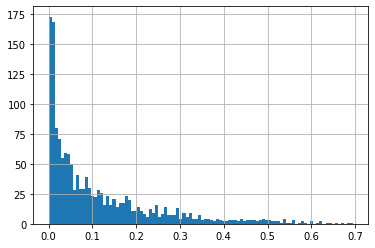

In [100]:
error["rel_error"].hist(bins=100)

Now, the great thing is that literally ALL OF THE ABOVE has been pacakged into a nice function for you, which returns both the trained model and this error dataframe! Simply run the `model_testing` function from the `mdp_model.py` file, and you will get these results!

## Visualization Tools

In the `mdp_testing.py` file, there are also various other visualization tools to help compare these results with real data! Most of these require you to have the original dataframe of the full data, as well as the clustered data which you can access at `model.df_trained`.

`plot_pred` allows us to visualize the predicted path of the model compared to the real evolution of the target value.

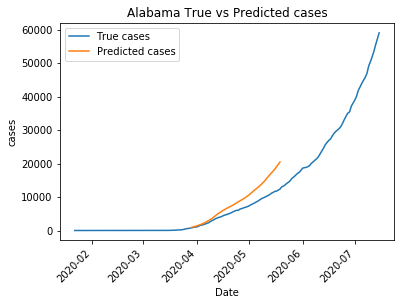

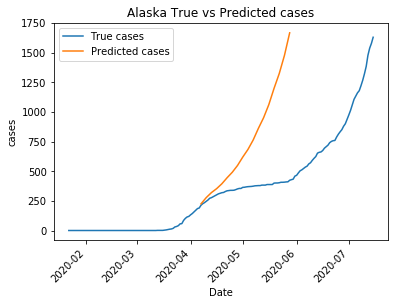

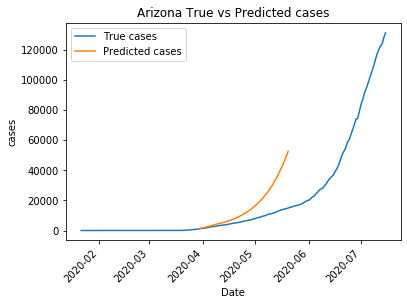

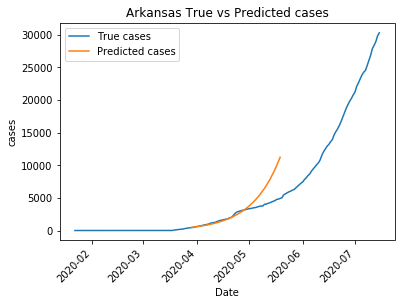

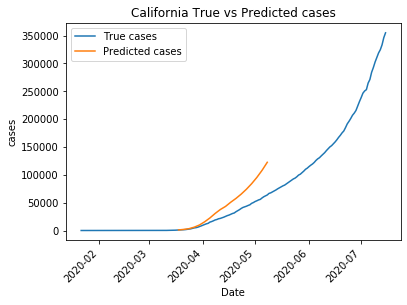

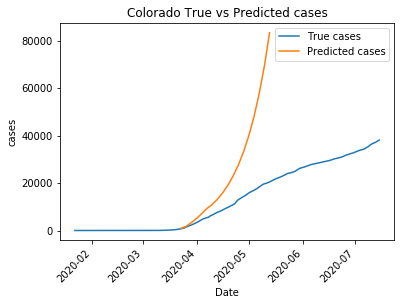

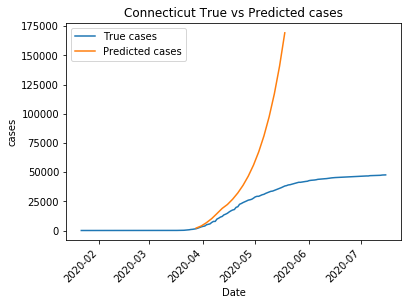

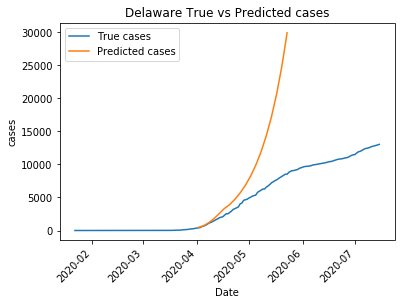

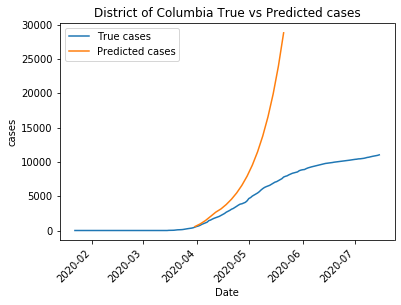

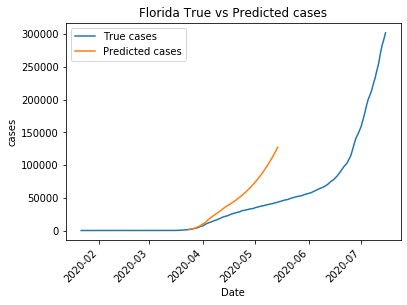

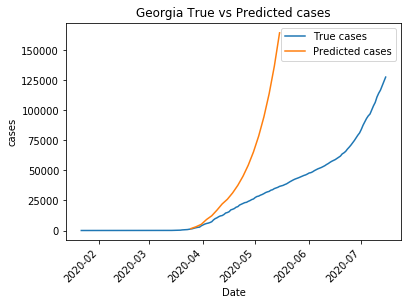

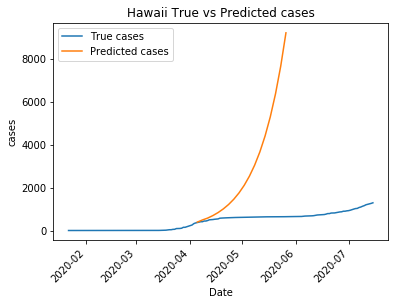

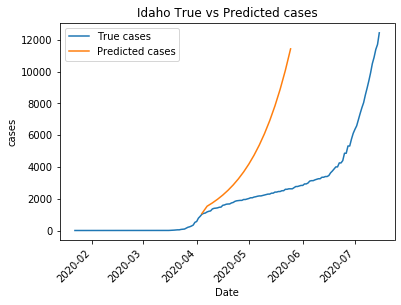

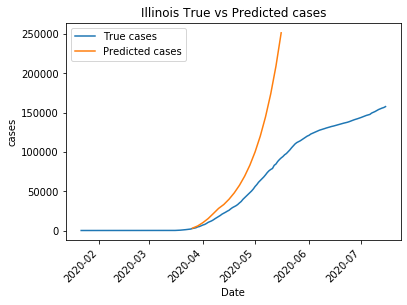

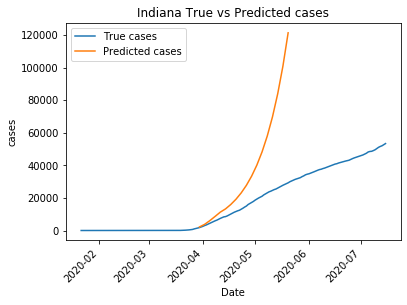

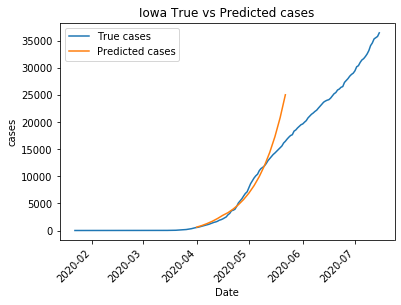

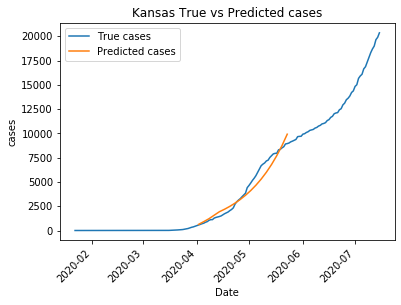

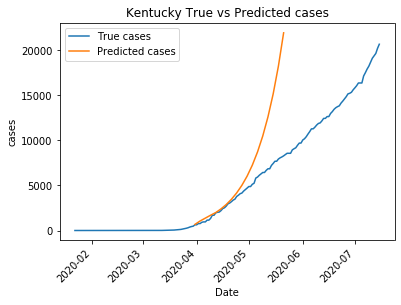

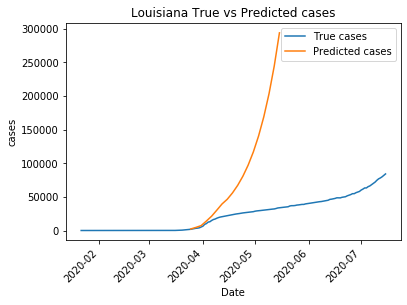

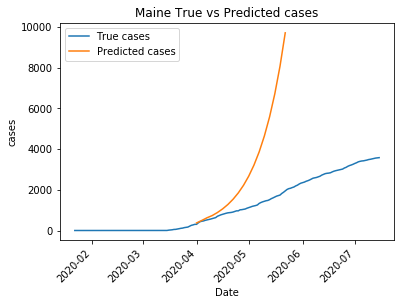

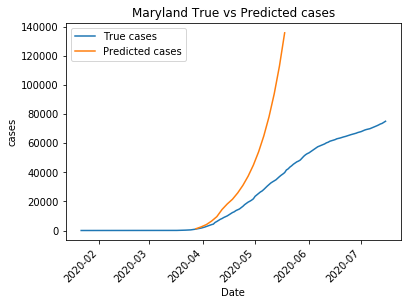

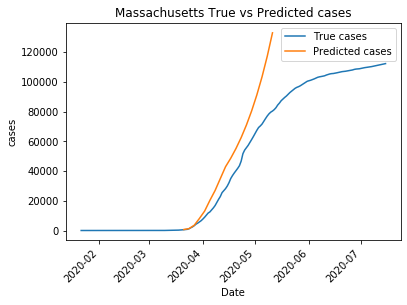

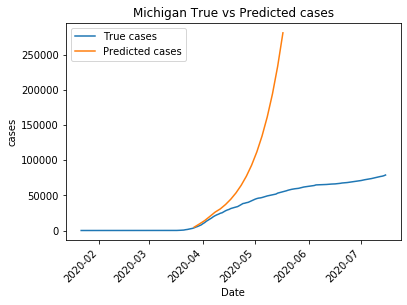

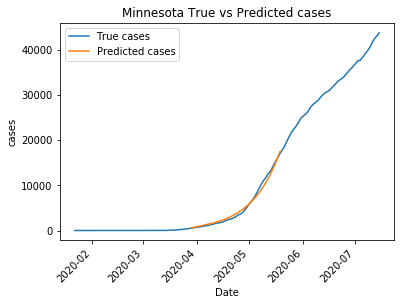

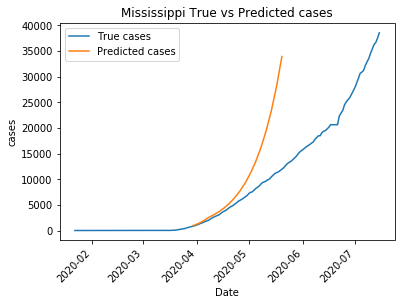

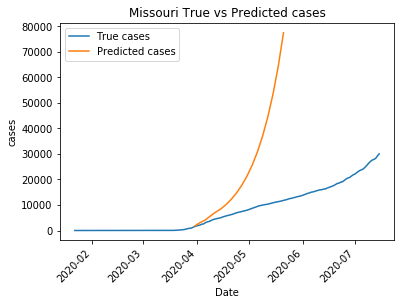

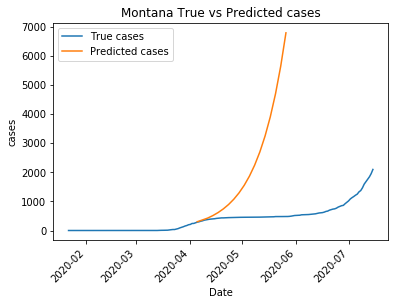

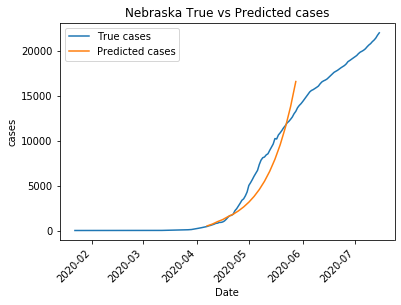

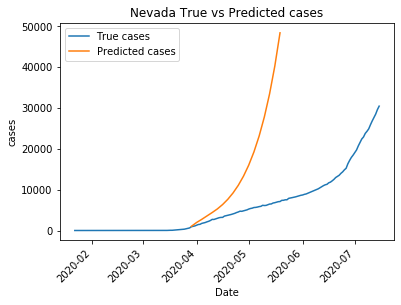

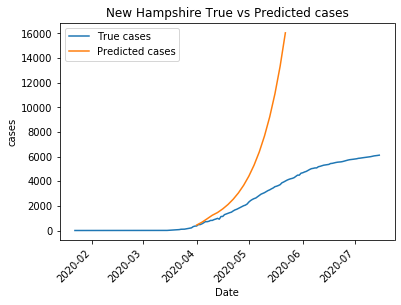

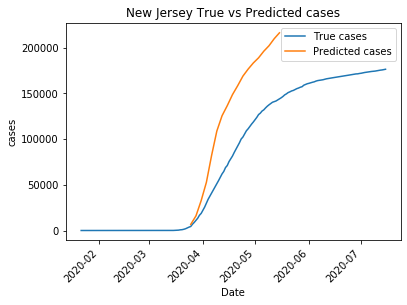

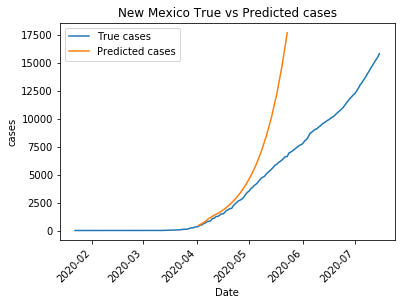

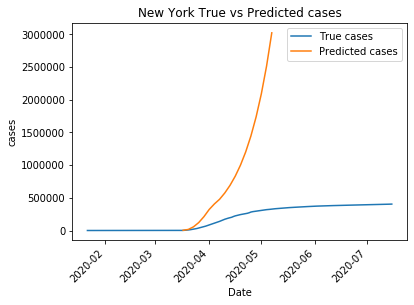

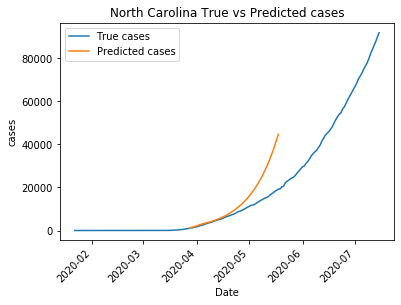

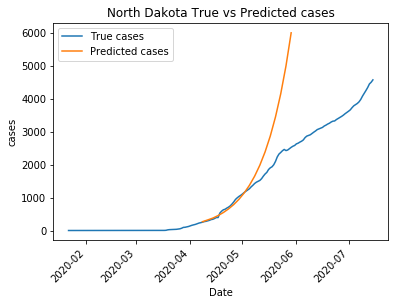

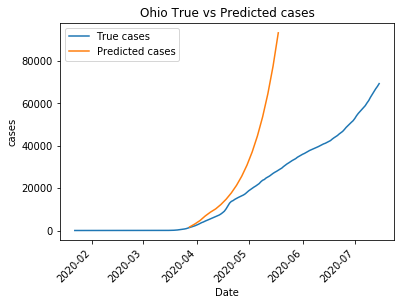

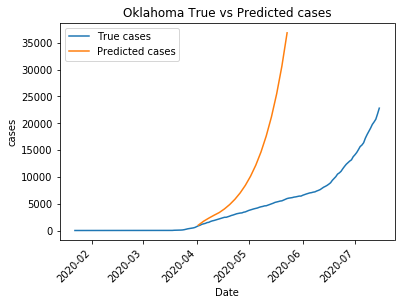

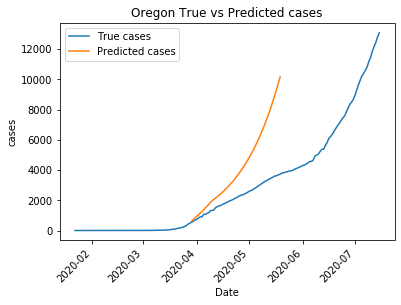

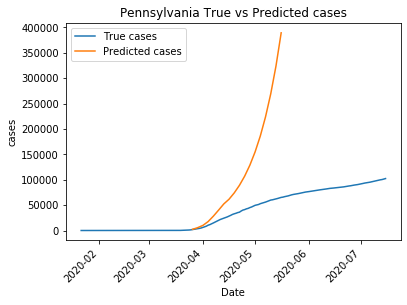

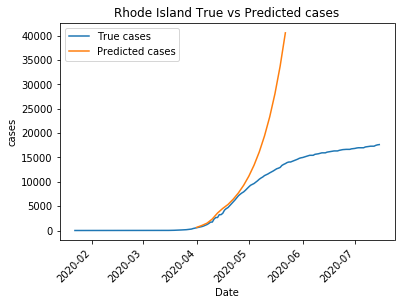

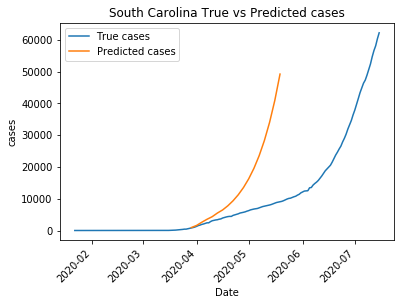

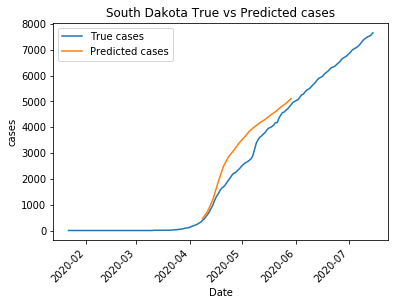

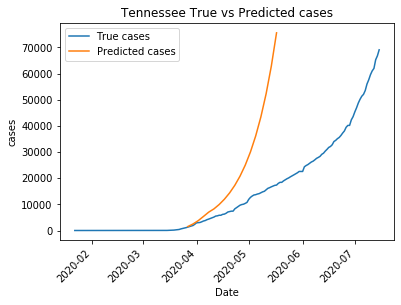

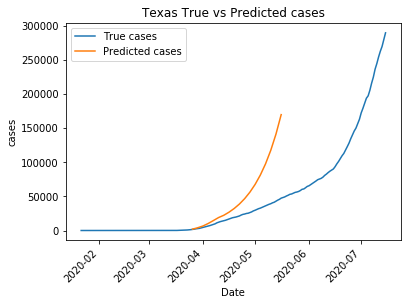

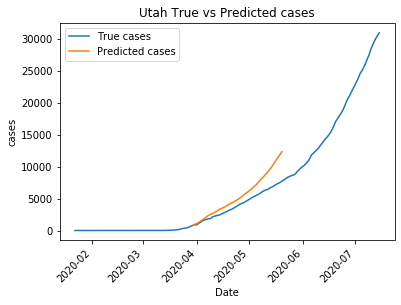

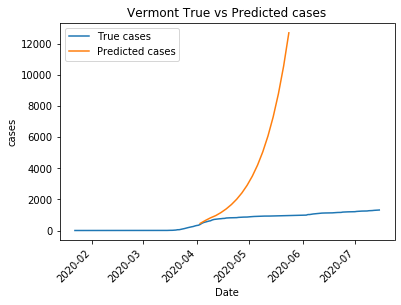

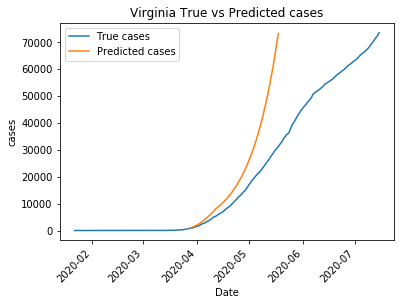

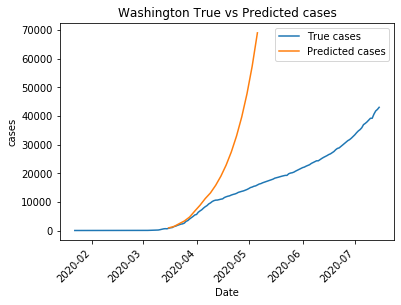

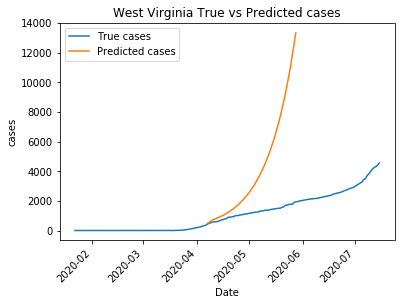

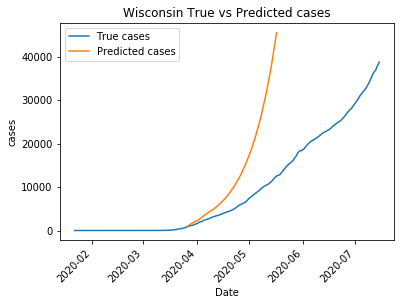

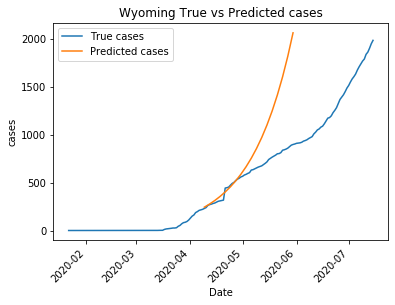

In [85]:
for region in m.df_trained.index:
    plot_pred(m, region, df, 50, from_first=True)

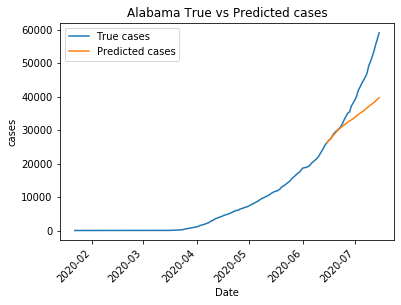

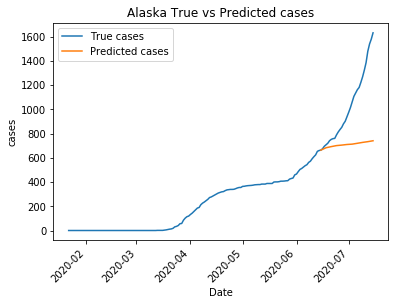

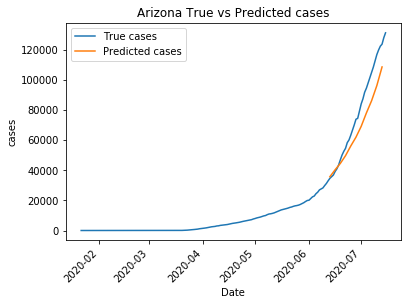

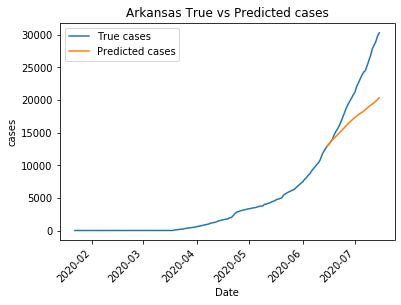

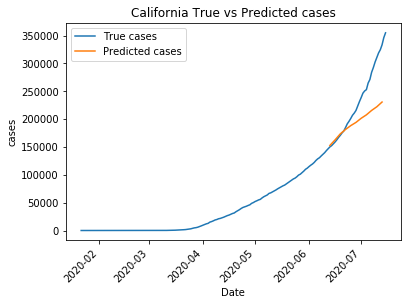

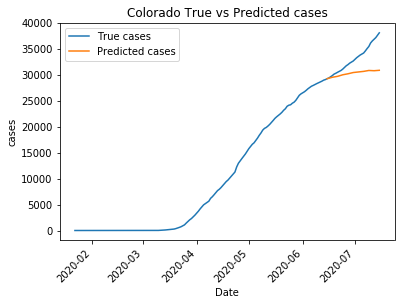

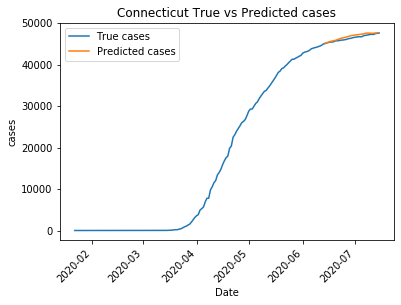

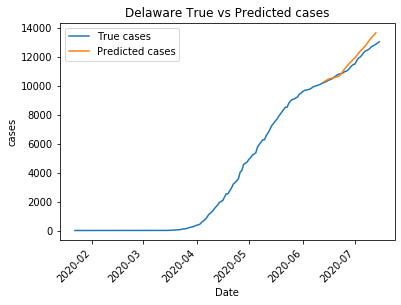

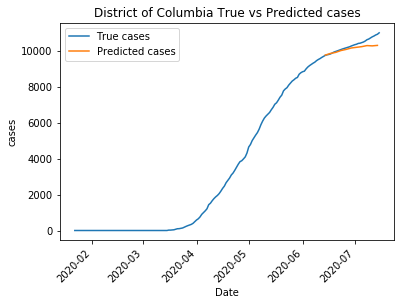

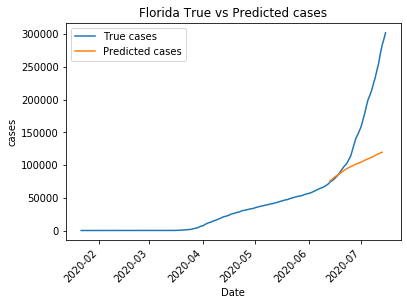

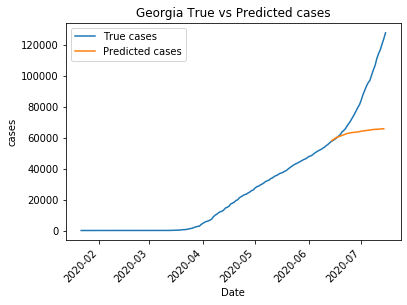

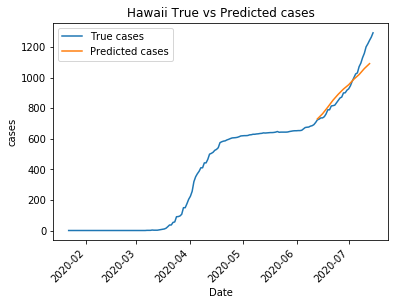

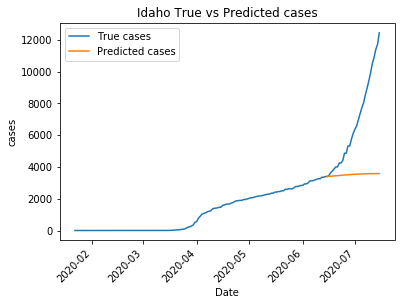

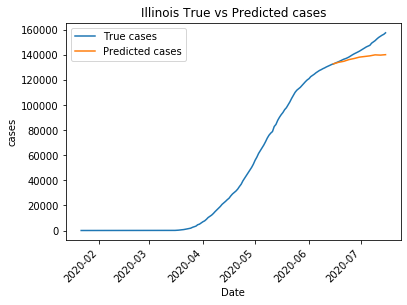

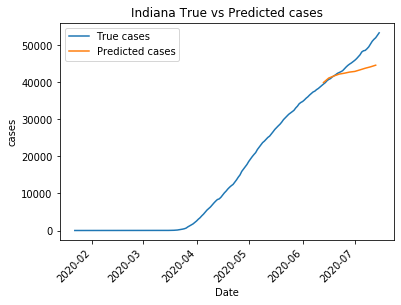

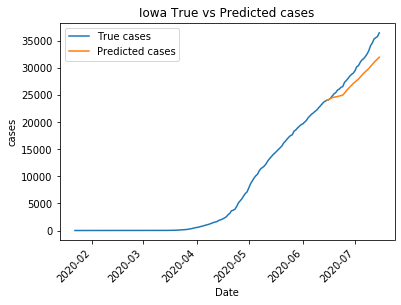

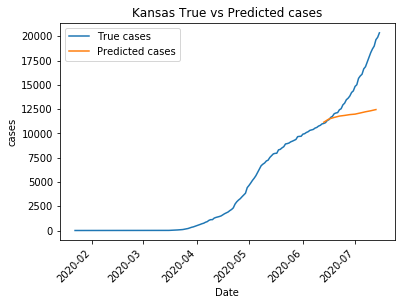

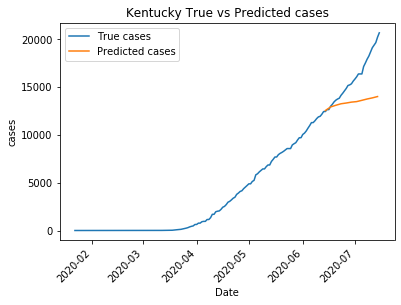

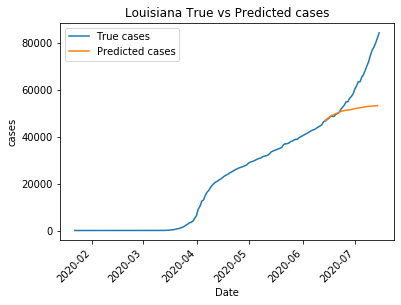

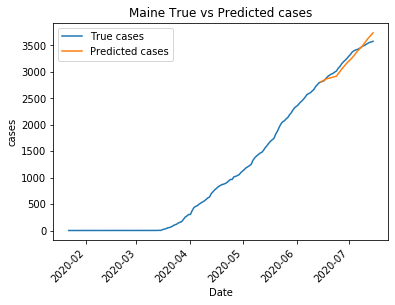

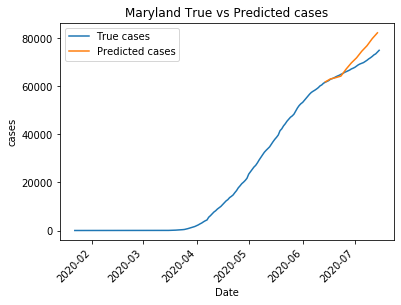

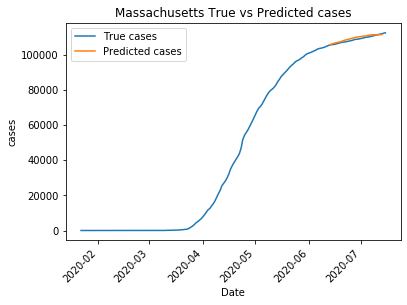

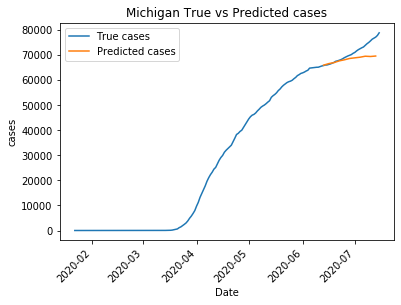

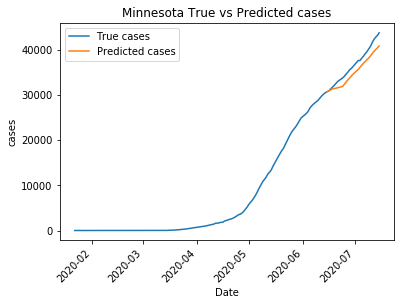

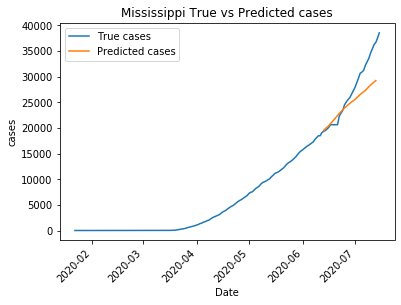

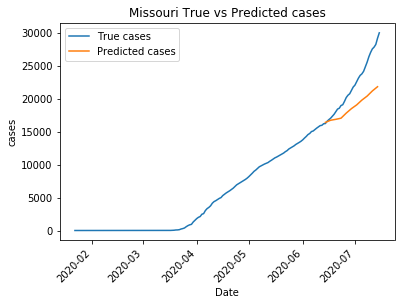

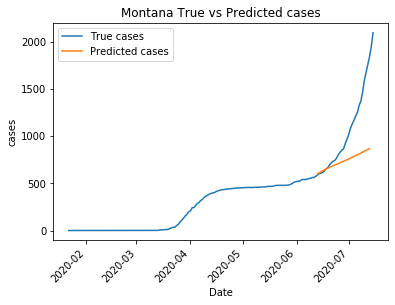

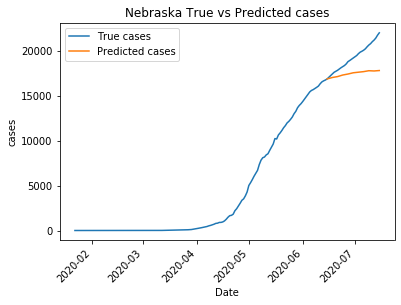

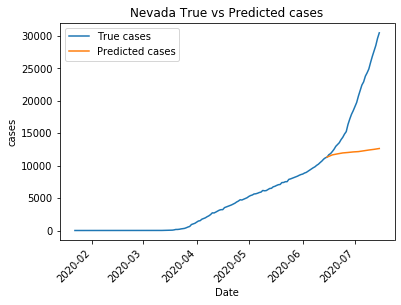

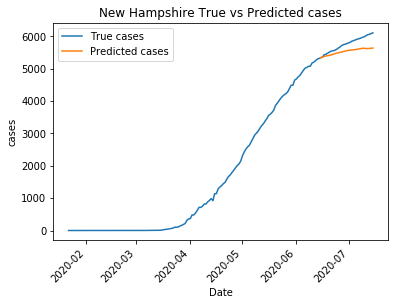

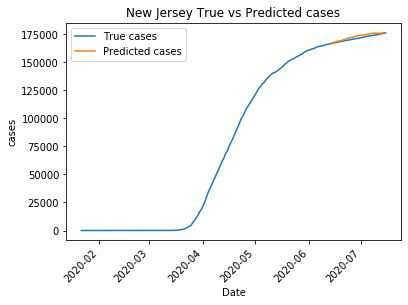

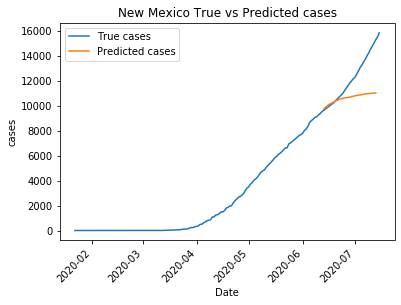

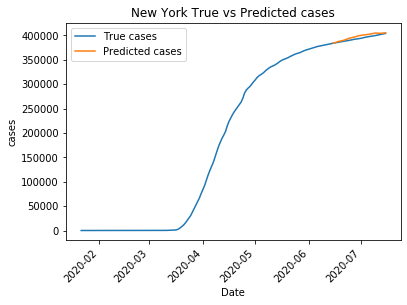

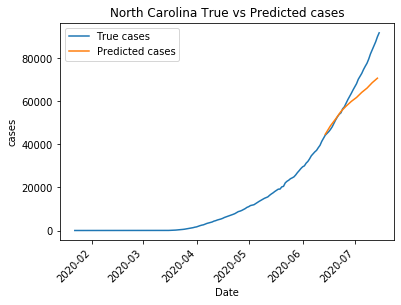

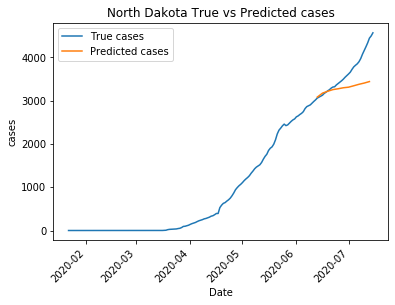

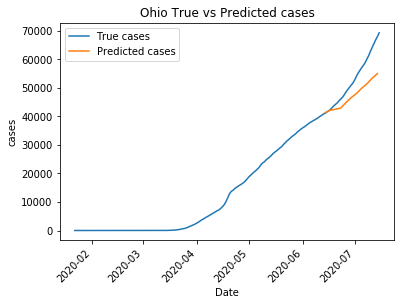

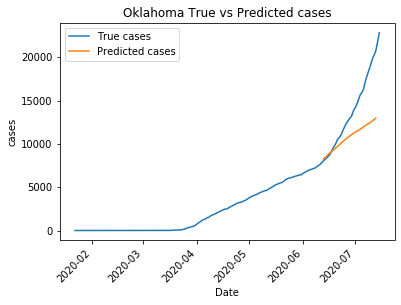

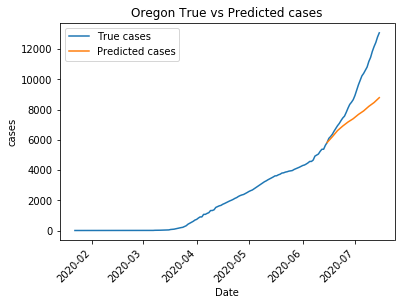

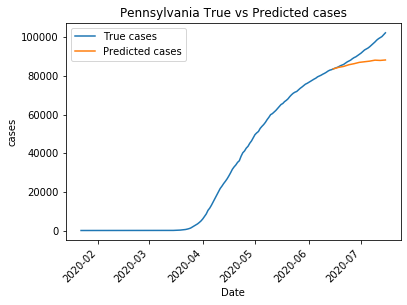

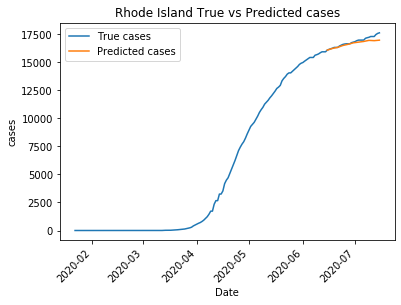

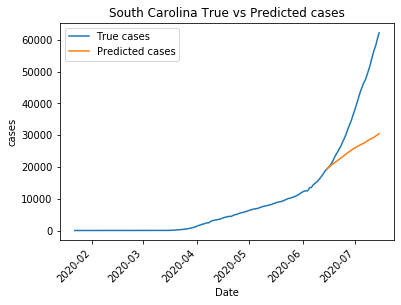

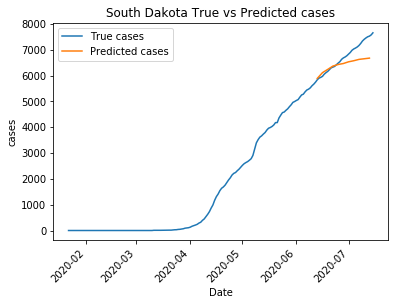

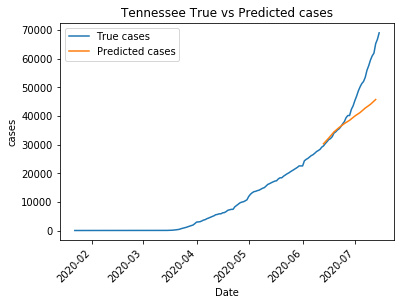

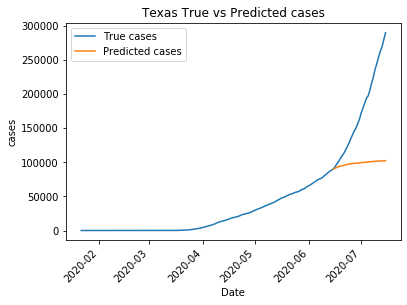

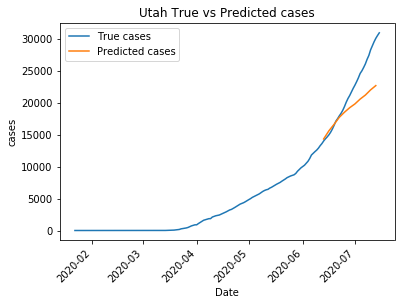

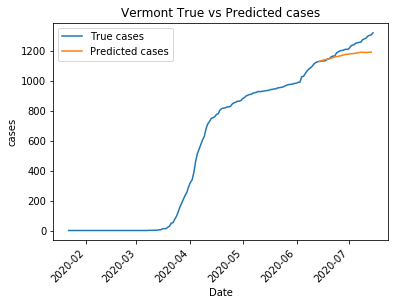

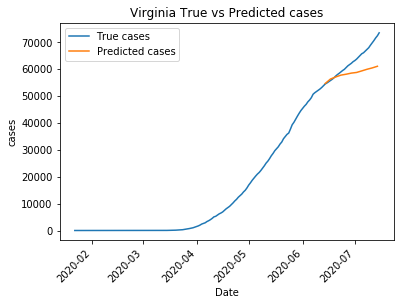

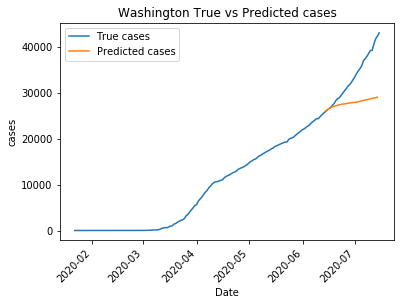

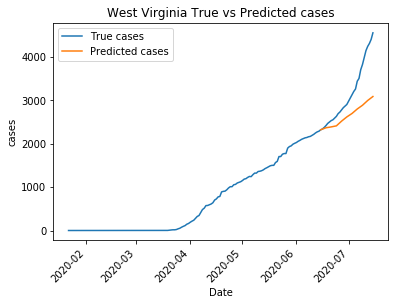

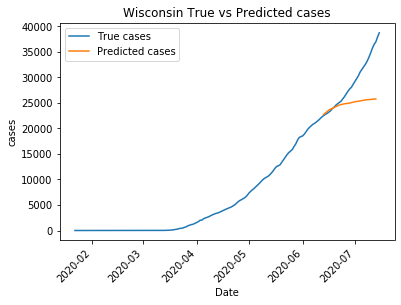

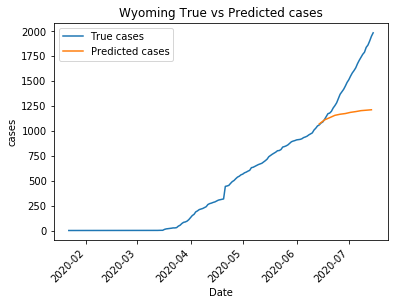

In [101]:
for region in m.df_trained.index:
    plot_pred(m, region, df, n_days, from_first=False)

## $\textbf{Grid Search Analysis}$

In [19]:
with open(os.path.join(MODEL_PATH, "mdp_gs_cases_wo_act.pickle"), 'rb') as filehandler:
    mgs = pickle.load(filehandler)

In [6]:
mgs.testing_error

{0: 0.04905599473922093,
 1: 0.04699905461008597,
 2: 0.11725798716676235,
 3: 0.11780364780184498,
 4: 0.572779629913963,
 5: 0.710317378733401,
 6: 0.06656367013281196,
 7: 0.0652597889122737,
 8: 0.16463223932306678,
 9: 0.16489206342650103,
 10: 4.03678140051655,
 11: 0.627548352500398,
 12: 0.08041912101287939,
 13: 0.09905220011979994,
 14: 0.24582251240394704,
 15: 0.2631216980346289,
 16: 0.5024158106922457,
 17: 0.4773146484350817}

In [7]:
mgs.best_estimator_

MDPModel(target=cases, horizon=5, days_avg=3,distance_threshold=10pct, n_iter=120, classification_algorithm=RandomForestClassifier, features_list=['mobility_score_trend', 'cases_pct3', 'cases_pct5'],action_thresh=([], 0))

In [8]:
import operator
key_opt = min(mgs.testing_error.items(), key=operator.itemgetter(1))[0]
m_opt = mgs.all_estimators_dict[key_opt]
m_opt

MDPModel(target=cases, horizon=5, days_avg=3,distance_threshold=10pct, n_iter=120, classification_algorithm=RandomForestClassifier, features_list=['mobility_score_trend', 'cases_pct3', 'cases_pct5'],action_thresh=([], 0))

In [9]:
m_opt.optimal_cluster_size

53

In [24]:
# Import full dataset and convert time col to time object
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))
df.loc[:, [date_colname]]= pd.to_datetime(df[date_colname])

df_pred = pd.concat([m_opt.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m_opt.region_colname, "TIME"]).join(df.rename(columns={m_opt.date_colname: "TIME"}).set_index([m_opt.region_colname, "TIME"])[m_opt.target_colname], lsuffix="_", rsuffix="").loc[:, [m_opt.target_colname]].reset_index().set_index(m_opt.region_colname)
df_pred.set_index(m_opt.region_colname, inplace=True)
error = mape(df_pred, df_true, m_opt.target_colname).reset_index()
error_state = error.drop("TIME", axis=1).groupby(m_opt.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

NameError: name 'm_opt' is not defined

In [17]:
# computing the out of sample error
error_state.describe()

rel_error
count  51.000000
mean    0.044044
std     0.034563
min     0.004303
25%     0.023550
50%     0.039705
75%     0.054594
max     0.223651

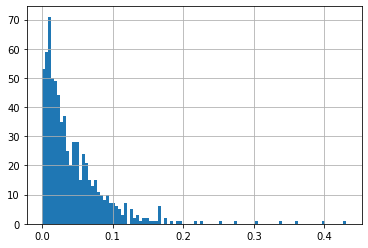

In [18]:
error["rel_error"].hist(bins=100)

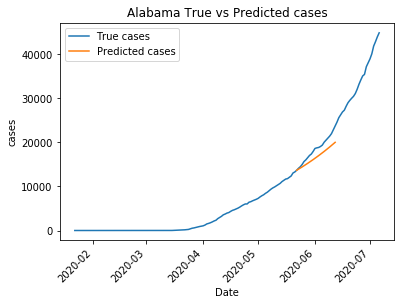

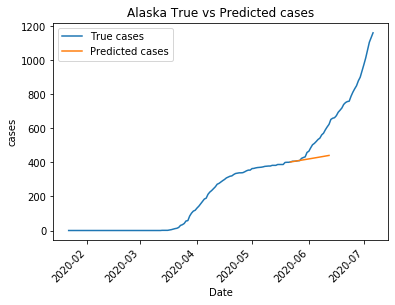

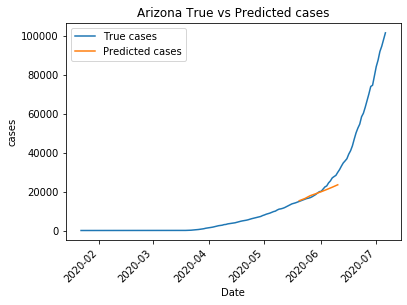

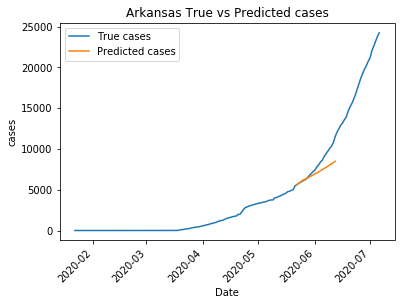

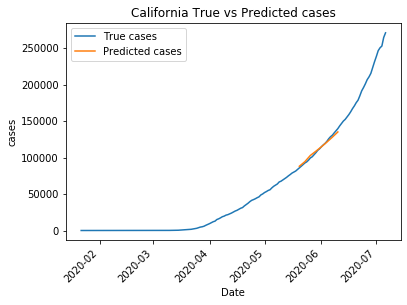

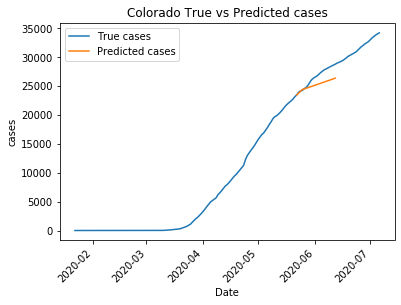

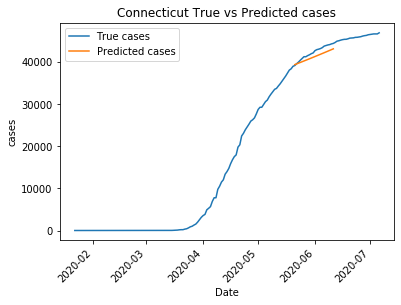

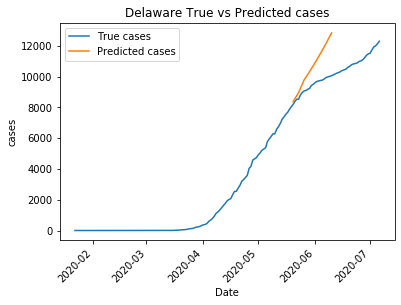

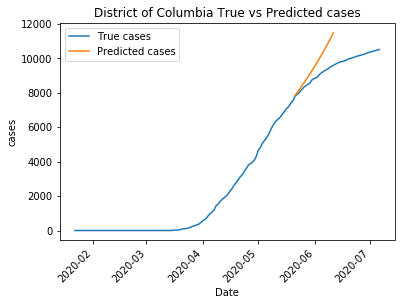

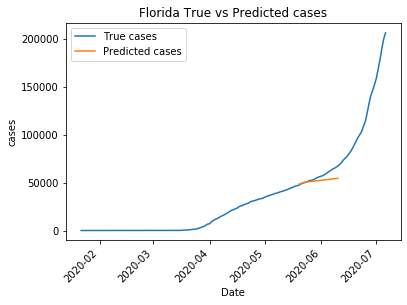

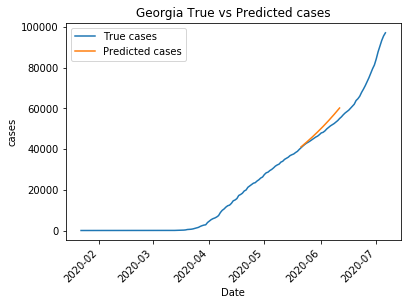

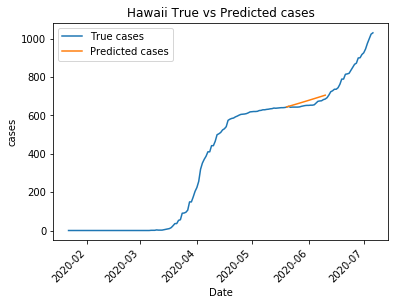

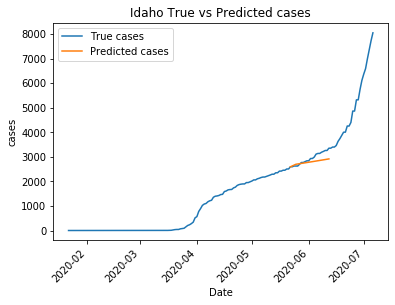

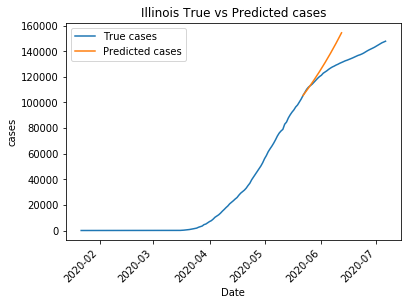

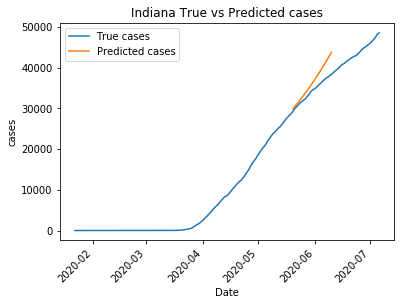

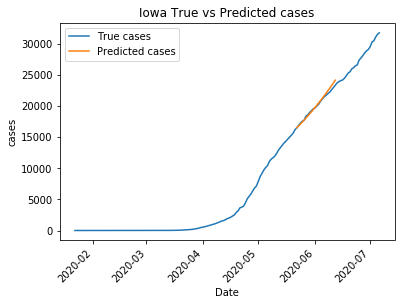

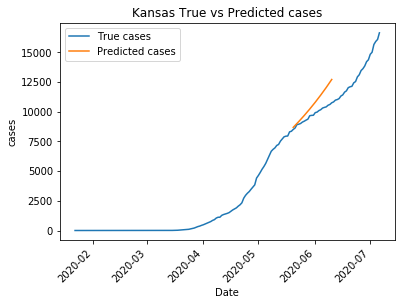

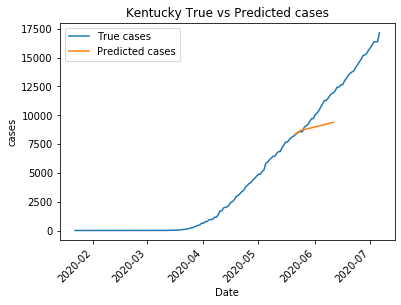

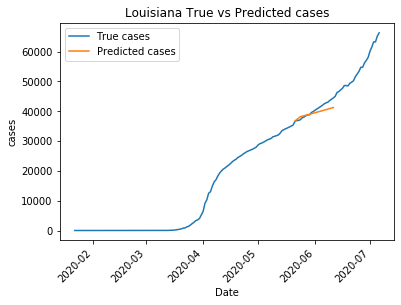

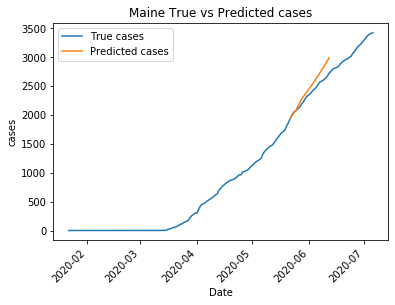

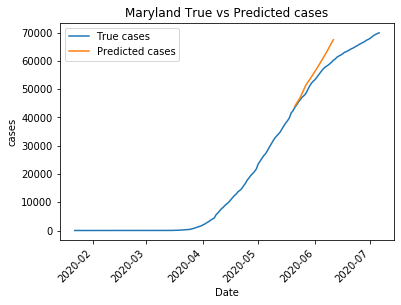

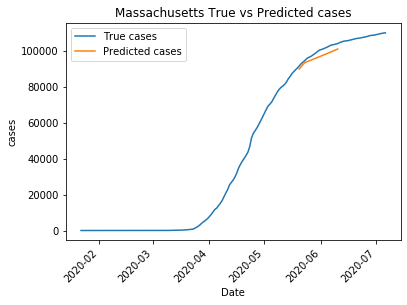

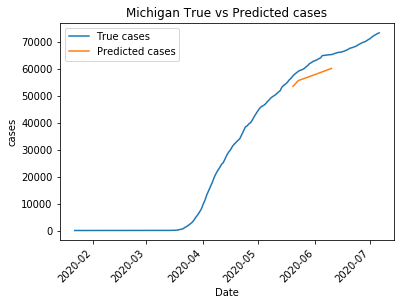

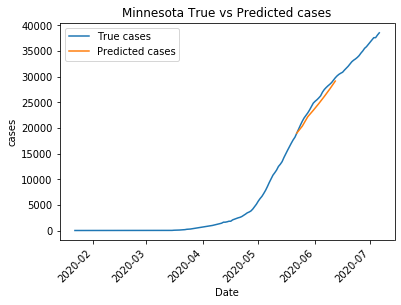

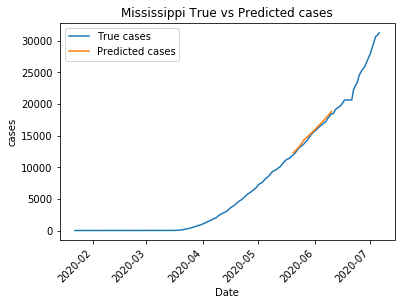

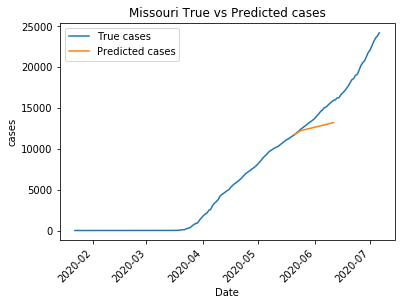

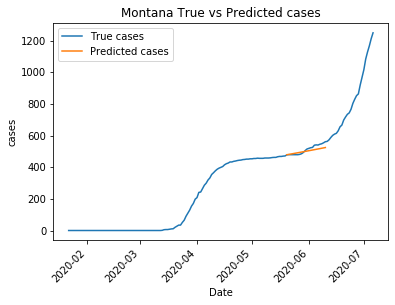

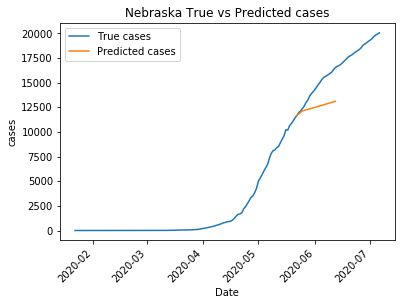

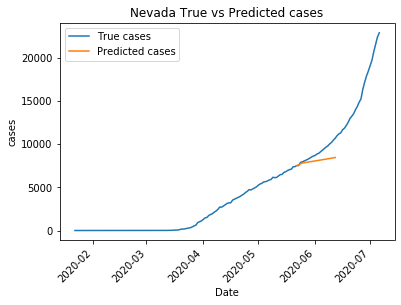

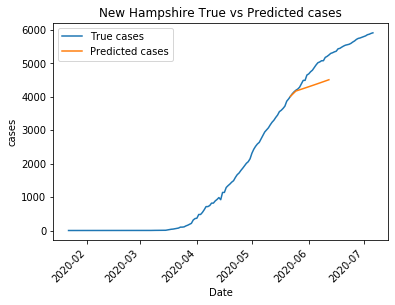

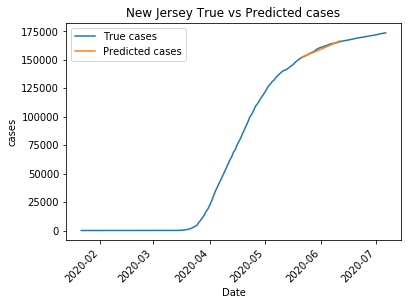

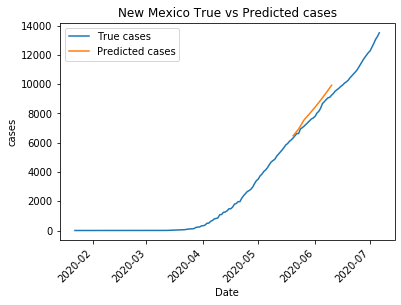

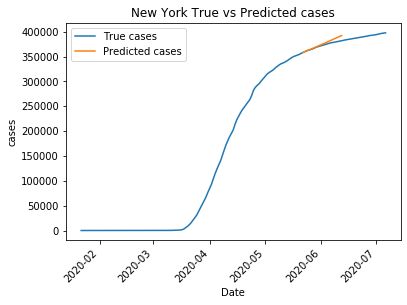

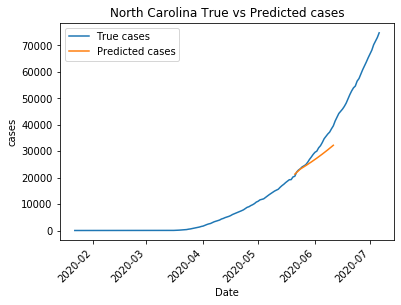

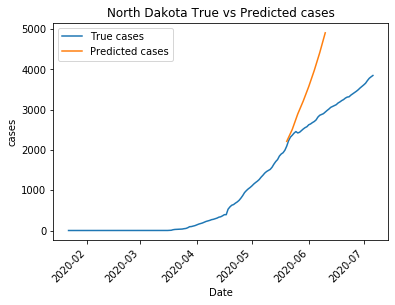

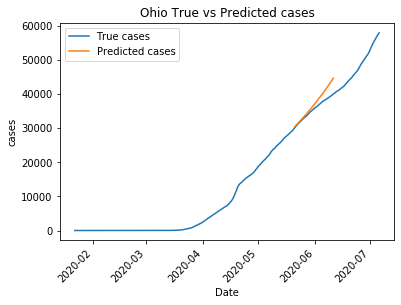

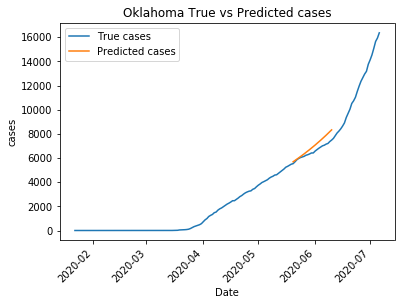

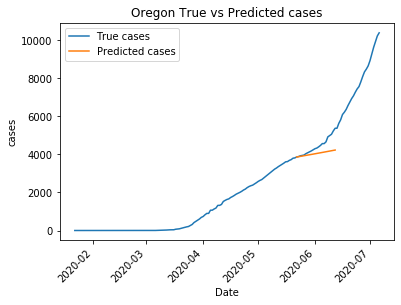

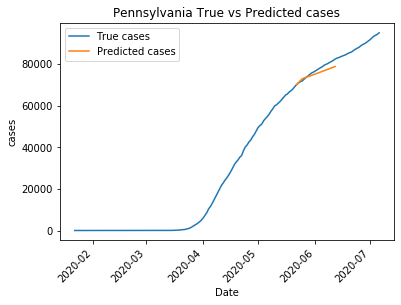

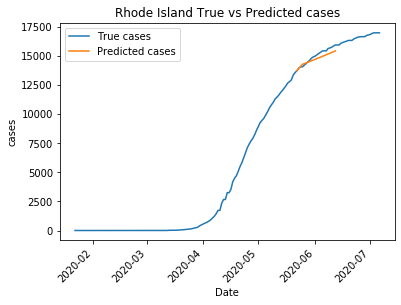

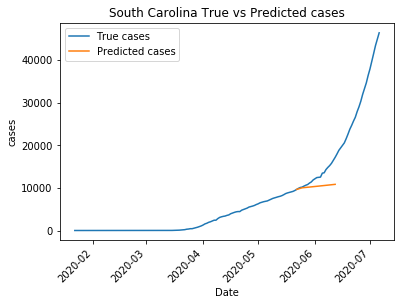

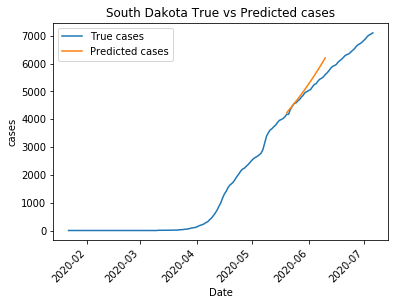

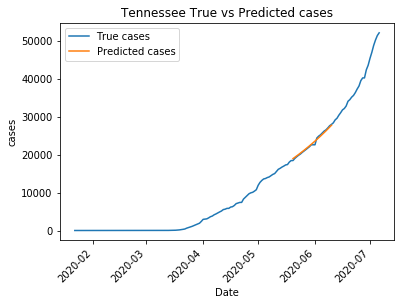

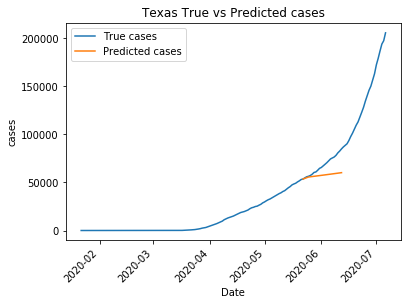

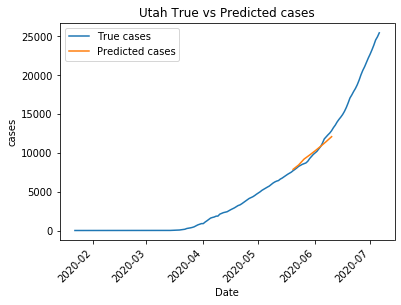

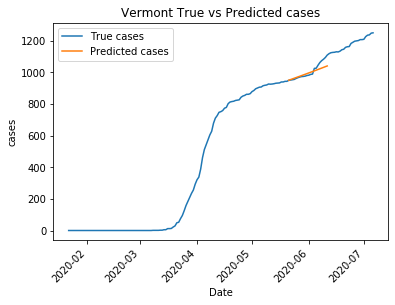

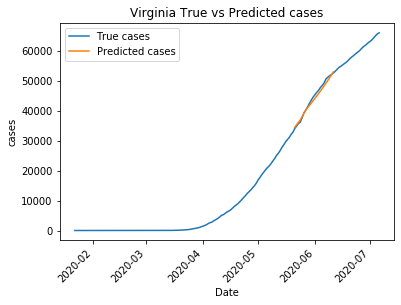

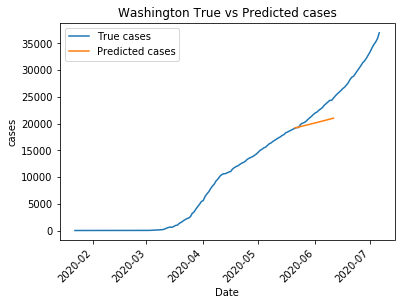

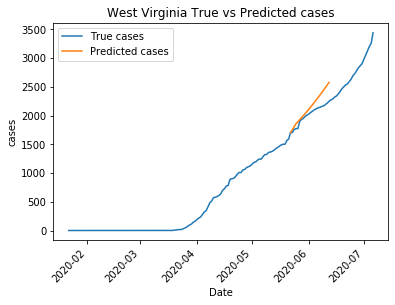

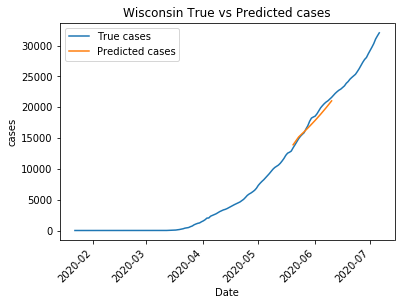

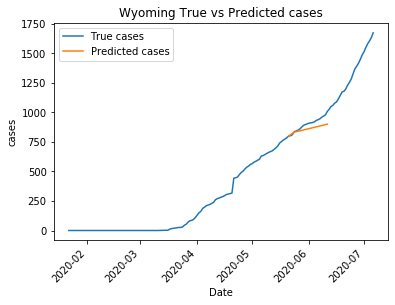

In [20]:
for region in m_opt.df_trained.index:
    plot_pred(m_opt, region, df, 20, from_first=False)

In [72]:
m.P_df

TRANSITION_CLUSTER
CLUSTER ACTION                    
0       0                     99.0
1       0                      1.0
2       0                     82.0
3       0                     84.0
4       0                      1.0
...                            ...
110     0                    110.0
111     0                     51.0
112     0                     69.0
113     0                     74.0
114     0                     95.0

[115 rows x 1 columns]